In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from category_encoders import MEstimateEncoder
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold,cross_val_score
from sklearn.metrics import mean_squared_error,make_scorer
from xgboost import XGBRegressor
import lightgbm as lgb
import nltk
# nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
# import nvtabular as nvt

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/can-i-be-an-influencer/sample_submission.csv
/kaggle/input/can-i-be-an-influencer/test_colors.csv
/kaggle/input/can-i-be-an-influencer/test_keywords.csv
/kaggle/input/can-i-be-an-influencer/train.csv
/kaggle/input/can-i-be-an-influencer/train_colors.csv
/kaggle/input/can-i-be-an-influencer/test.csv
/kaggle/input/can-i-be-an-influencer/train_keywords.csv


In [3]:
# pip install category_encoders
path='/kaggle/input/can-i-be-an-influencer/'

In [4]:
train = pd.read_csv(path+'train.csv')
train_colors= pd.read_csv(path+'train_colors.csv')
train_keywords= pd.read_csv(path+'train_keywords.csv')
test= pd.read_csv(path+'test.csv')
test_colors= pd.read_csv(path+'test_colors.csv')
test_keywords= pd.read_csv(path+'test_keywords.csv')
sample_submission= pd.read_csv(path+'sample_submission.csv')

In [5]:
pd.set_option('display.max_columns', 100)

In [6]:
train.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,Pristine water lily,rule of thirds photography of pink and white l...,Canon,Canon EOS 60D,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,NaN,sand in desert,SONY,ILCE-6500,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,NaN,green trees near brown mountain during daytime,NIKON CORPORATION,NIKON D850,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,NaN,gray dock aerial photography,DJI,FC220,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,NaN,people walking on green grass field near lake ...,FUJIFILM,X-T10,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982


In [7]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = (df.isnull().sum().values / len(df)) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [8]:
summary(train)

data shape: (12197, 26)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.000000,12197,NaN,NaN,68105c019b,06d11c4edd,f6599edba1
photo_url,object,0,0.000000,12197,NaN,NaN,https://unsplash.com/photos/7AcMUSYRZpU,https://unsplash.com/photos/grWwLCSRr4o,https://unsplash.com/photos/OR4q9_Y2nuY
photo_image_url,object,0,0.000000,12197,NaN,NaN,https://images.unsplash.com/photo-147455715737...,https://images.unsplash.com/photo-157005349769...,https://images.unsplash.com/photo-158018448188...
photo_submitted_at,object,0,0.000000,12187,NaN,NaN,2016-09-22 15:13:10.134081,2019-10-02 21:59:51.712464,2020-01-28 04:10:11.128061
obs_day,object,0,0.000000,7,NaN,NaN,Thursday,Wednesday,Tuesday
obs_hour,int64,0,0.000000,24,0.0,23.0,15,21,4
obs_min,int64,0,0.000000,60,0.0,59.0,13,59,10
obs_sec,int64,0,0.000000,60,0.0,59.0,10,51,11
image_category,object,0,0.000000,2,NaN,NaN,Featured,Featured,Featured
width,int64,0,0.000000,2792,1275.0,16384.0,2592,4000,5504


In [9]:
train[train['image_id'] == '547eda8452']

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads
5933,547eda8452,https://unsplash.com/photos/tPGDYGDVT-w,https://images.unsplash.com/photo-1545703528-7...,2018-12-25 02:06:27.119707,Tuesday,2,6,27,Featured,5048,3508,1.44,NaN,selective focus photography of brown ant on gr...,Canon,Canon EOS 750D,160.0,5.6,100.0,1/160,NaN,NaN,NaN,NaN,1537,4270


In [10]:
train['image_category'].value_counts()

Featured        12096
Not Featured      101
Name: image_category, dtype: int64

In [11]:
summary(train_colors)

data shape: (119891, 8)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.0,12185,NaN,NaN,34d72beca9,547eda8452,f6200aa06c
R,int64,0,0.0,256,0.0,255.0,69,132,189
G,int64,0,0.0,256,0.0,255.0,112,162,192
B,int64,0,0.0,256,0.0,255.0,154,88,194
image_hex,object,0,0.0,108035,NaN,NaN,45709A,84A258,BDC0C2
keyword,object,0,0.0,139,NaN,NaN,steelblue,gray,silver
pixel_coverage,float64,0,0.0,36600,0.000044,1.0,0.130267,0.035833,0.0775
color_score,float64,0,0.0,119693,0.0,1.0,0.093075,0.192869,0.040238


In [12]:
train_colors[train_colors['image_id'] == 'a2a5392b20'].sort_values(by='color_score', ascending=False)

,image_id,R,G,B,image_hex,keyword,pixel_coverage,color_score
84976,a2a5392b20,49,94,84,315e54,darkslategray,0.145589,0.262343
71064,a2a5392b20,80,125,112,507d70,dimgray,0.128620,0.249227
67083,a2a5392b20,115,160,145,73a091,cadetblue,0.054141,0.115543
80806,a2a5392b20,55,127,105,377f69,seagreen,0.003300,0.060098
80805,a2a5392b20,25,63,55,193f37,darkslategray,0.072593,0.048577
92701,a2a5392b20,73,87,90,49575a,darkslategray,0.109764,0.044692
84975,a2a5392b20,41,54,57,293639,darkslategray,0.189562,0.038081
66232,a2a5392b20,29,102,80,1d6650,darkslategray,0.001414,0.033967
84977,a2a5392b20,106,119,120,6a7778,dimgray,0.067071,0.030810
73609,a2a5392b20,156,198,188,9cc6bc,silver,0.008283,0.016881


In [13]:
print('sum of pixel coverage:{}'.format(train_colors[train_colors['image_id'] == 'a2a5392b20']['pixel_coverage'].sum()),
'sum of color score: {}'.format(train_colors[train_colors['image_id'] == 'a2a5392b20']['color_score'].sum()))

sum of pixel coverage:0.7803366977999996 sum of color score: 0.9002201669999992


I'm not sure how this data set is created, have asked for more clarity. However, from what it seems to be multiple points have been taken and the values are given based on that.
I think they are using basic image processing algorithm to get all the colours in the image, we can use it to create features like total colours or may be just take the most dominant colour of all.

## Preprocessing Colour Data

In [14]:
def preprocess_color(data):
    
    data_grp=data.groupby(['image_id','keyword']).agg({'pixel_coverage':'sum','color_score':'sum'}).reset_index()
    data_grp.sort_values(by=['image_id','color_score','pixel_coverage'], ascending=False,inplace=True)
    data_grp['color_cnt']=data_grp.groupby('image_id')['keyword'].transform('nunique')
    data_tc = data_grp.groupby('image_id').first().reset_index()
    data_tc=data_tc.rename(columns = {'keyword':'dominant_clr'})
    
    return data_tc

In [15]:
train_colors_grp= train_colors.groupby(['image_id','keyword']).agg({'pixel_coverage':'sum','color_score':'sum'}).reset_index()
train_colors_grp[train_colors_grp['image_id'] == 'a2a5392b20'].sort_values(by=['color_score','pixel_coverage'], ascending=False)

,image_id,keyword,pixel_coverage,color_score
53524,a2a5392b20,darkslategray,0.518923,0.427661
53525,a2a5392b20,dimgray,0.195690,0.280037
53523,a2a5392b20,cadetblue,0.054141,0.115543
53526,a2a5392b20,seagreen,0.003300,0.060098
53527,a2a5392b20,silver,0.008283,0.016881


In [16]:
train_colors_grp.sort_values(by=['image_id','color_score','pixel_coverage'], ascending=False,inplace=True)

In [17]:
train_colors_grp['color_cnt']=train_colors_grp.groupby('image_id')['keyword'].transform('nunique')
train_colors_grp[train_colors_grp['image_id'] == 'a2a5392b20']

,image_id,keyword,pixel_coverage,color_score,color_cnt
53524,a2a5392b20,darkslategray,0.518923,0.427661,5
53525,a2a5392b20,dimgray,0.195690,0.280037,5
53523,a2a5392b20,cadetblue,0.054141,0.115543,5
53526,a2a5392b20,seagreen,0.003300,0.060098,5
53527,a2a5392b20,silver,0.008283,0.016881,5


In [18]:
train_colors_grp.color_cnt.value_counts()

7     23037
8     20888
6     14748
9     11844
5      6715
10     3720
4      2284
3       513
2        98
1         3
Name: color_cnt, dtype: int64

In [19]:
train_colors_tc = train_colors_grp.groupby('image_id').first().reset_index()
train_colors_tc.head()

,image_id,keyword,pixel_coverage,color_score,color_cnt
0,000060f5b4,gainsboro,0.307847,0.334070,7
1,00048eb0af,darkslategray,0.391340,0.404677,5
2,000a71e54b,whitesmoke,0.247400,0.239408,9
3,000ad1b637,darkslategray,0.290800,0.282744,6
4,00192ccaaa,darkslategray,0.411733,0.279946,5


In [20]:
train_colors_tc=train_colors_tc.rename(columns = {'keyword':'dominant_clr'})

In [21]:
summary(train_colors_tc)

data shape: (12185, 5)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.0,12185,NaN,NaN,000060f5b4,00048eb0af,000a71e54b
dominant_clr,object,0,0.0,122,NaN,NaN,gainsboro,darkslategray,whitesmoke
pixel_coverage,float64,0,0.0,11717,0.000198,1.0,0.307847,0.39134,0.2474
color_score,float64,0,0.0,12177,0.031425,1.0,0.33407,0.404677,0.239408
color_cnt,int64,0,0.0,10,1.0,10.0,7,5,9


Now we have single row for each image id in the train colors data set, however there are 12 images for which the data is missing. We will now join the data with train_df

In [22]:
train_df= train.merge(train_colors_tc, on='image_id', how='left')
train_df.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,Pristine water lily,rule of thirds photography of pink and white l...,Canon,Canon EOS 60D,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,thistle,0.054467,0.313672,8.0
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,NaN,sand in desert,SONY,ILCE-6500,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839,bisque,0.067400,0.468920,9.0
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,NaN,green trees near brown mountain during daytime,NIKON CORPORATION,NIKON D850,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787,dimgray,0.156467,0.463431,8.0
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,NaN,gray dock aerial photography,DJI,FC220,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049,dimgray,0.517937,0.664781,7.0
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,NaN,people walking on green grass field near lake ...,FUJIFILM,X-T10,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982,steelblue,0.093867,0.170882,8.0


In [23]:
train.shape, train_df.shape

((12197, 26), (12197, 30))

In [24]:
train_df['dominant_clr'].value_counts().head()

darkslategray     2162
silver             956
darkolivegreen     804
dimgray            735
black              585
Name: dominant_clr, dtype: int64

In [25]:
test_color_tc = preprocess_color(test_colors)
test_color_tc.head()

,image_id,dominant_clr,pixel_coverage,color_score,color_cnt
0,000699494b,darkslategray,0.312467,0.331833,7
1,000f885489,teal,0.684667,0.776322,3
2,0015cd0816,olivedrab,0.005533,0.223022,9
3,00165430c3,crimson,0.018667,0.232093,7
4,0034f3dd03,black,0.086028,0.491707,5


In [26]:
test_df= test.merge(test_color_tc, on='image_id', how='left')
test_df.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,dominant_clr,pixel_coverage,color_score,color_cnt
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,6016,0.67,NaN,brown leaf,NIKON CORPORATION,NIKON D750,100.0,4.5,50.0,1/640,NaN,NaN,NaN,NaN,1249,darkolivegreen,0.018533,0.259108,5.0
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,4160,1.50,NaN,gray seal,Canon,Canon EOS 6D Mark II,100.0,5.6,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211,gray,0.181267,0.345520,7.0
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,3648,1.50,NaN,NaN,Canon,Canon EOS 6D,100.0,7.1,50.0,1/1000,NaN,NaN,NaN,NaN,1439,mediumaquamarine,0.128667,0.296128,8.0
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,6000,0.67,NaN,landscape photography of desert,SONY,ILCE-7M2,100.0,8.0,85.0,1/200,NaN,NaN,NaN,NaN,1194,darkslategray,0.329267,0.489937,7.0
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,4000,1.50,NaN,brown grass,SONY,ILCE-6000,160.0,5.6,93.0,1/160,NaN,NaN,NaN,NaN,1457,darkgray,0.158067,0.601419,6.0


In [27]:
test.shape, test_df.shape

((6568, 25), (6568, 29))

In [28]:
test_df['dominant_clr'].value_counts().head()

darkslategray     1174
silver             453
dimgray            443
darkolivegreen     407
darkgray           346
Name: dominant_clr, dtype: int64

### Adding more color related variables**

In [29]:
import colorsys

def map_color_category(r, g, b):
    """Maps an R,G,B color value to a color category."""
    # Convert R,G,B values to HSV color space
    h, _, _ = colorsys.rgb_to_hsv(r/255, g/255, b/255)
    
    # Define color category thresholds
    warm_hues = ((0, 60), (300, 360)) # Red, Orange, Yellow
    cool_hues = ((120, 240),)        # Green, Blue, Purple
    
    # Map color to category
    if any(start <= h <= end for (start, end) in warm_hues):
        return "warm"
    elif any(start <= h <= end for (start, end) in cool_hues):
        return "cool"
    else:
        return "neutral"


In [30]:
from scipy.stats import entropy
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

def calculate_color_features(data):
    # Initialize empty dictionary to store results
    results = {}
    
    for image_id in tqdm(data['image_id'].unique()):
        
        image_data = data[data['image_id'] == image_id][['R', 'G', 'B']]
        
        # Calculate color histogram
        hist, _ = np.histogramdd(image_data.values, bins=16, range=((0, 255), (0, 255), (0, 255)))
        hist = hist / hist.sum()
        
        # Calculate dominant color
        dominant_color = tuple(image_data.apply(lambda x: np.mean(x), axis=0).astype(int).values.tolist())
        
        # Calculate color variance
        variance = np.var(image_data, axis=0).sum()
        
        # Calculate color entropy
        p = hist.flatten() / hist.sum()
        entropy_val = entropy(p)
        
        # Calculate color similarity
        distance_matrix = pairwise_distances(image_data, metric='euclidean')
        similarity = 1 / (1 + distance_matrix.mean())
        
        results[image_id] = {'dominant_color': dominant_color,
                             'variance': variance,
                             'entropy': entropy_val,
                             'similarity': similarity}
    
    # Convert dictionary to DataFrame and return
    results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
    results_df.rename(columns={'index': 'image_id'}, inplace=True)
        
    results_df[['dominant_color_R','dominant_color_G','dominant_color_B']] = results_df['dominant_color'].apply(lambda x: pd.Series([int(i.strip()) for i in str(x).strip('()').split(',')]))
    results_df.drop('dominant_color', axis=1, inplace=True)
    
#     results_df["color_category"] = results_df.apply(lambda row: map_color_category(row["dominant_color_R"], row["dominant_color_G"], row["dominant_color_B"]), axis=1)

    return results_df


In [31]:
train_color_features = calculate_color_features(train_colors)
train_color_features.head()

100%|██████████| 12185/12185 [02:08<00:00, 94.47it/s]


,image_id,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B
0,34d72beca9,5681.49,2.302585,0.011193,106,128,149
1,547eda8452,9138.10,2.302585,0.008706,119,104,60
2,f6200aa06c,14175.86,2.302585,0.007506,92,102,102
3,eb8b9707b6,4263.50,2.302585,0.012861,79,76,51
4,772ada1ab7,6841.30,2.302585,0.010387,131,124,104


In [32]:
test_color_features = calculate_color_features(test_colors)
test_color_features.head()

100%|██████████| 6562/6562 [00:47<00:00, 137.40it/s]


,image_id,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B
0,397ed421af,9536.54,2.302585,0.008470,200,192,142
1,d19c7e5807,1637.25,2.163956,0.020709,138,53,38
2,fd9099f9f3,8665.32,2.302585,0.009197,106,144,162
3,3de0532101,9801.71,2.302585,0.008709,162,139,113
4,ffd6334b9f,13441.90,2.302585,0.007413,118,141,172


In [33]:
train_df= train_df.merge(train_color_features, on='image_id', how='left')
train_df.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,Pristine water lily,rule of thirds photography of pink and white l...,Canon,Canon EOS 60D,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.008150,151.0,146.0,139.0
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,NaN,sand in desert,SONY,ILCE-6500,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839,bisque,0.067400,0.468920,9.0,13864.19,2.163956,0.007673,183.0,163.0,150.0
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,NaN,green trees near brown mountain during daytime,NIKON CORPORATION,NIKON D850,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787,dimgray,0.156467,0.463431,8.0,11015.06,2.163956,0.008315,122.0,122.0,111.0
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,NaN,gray dock aerial photography,DJI,FC220,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049,dimgray,0.517937,0.664781,7.0,7146.05,2.302585,0.010369,139.0,126.0,121.0
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,NaN,people walking on green grass field near lake ...,FUJIFILM,X-T10,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982,steelblue,0.093867,0.170882,8.0,9143.18,2.302585,0.008537,142.0,155.0,112.0


In [34]:
test_df= test_df.merge(test_color_features, on='image_id', how='left')
test_df.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,6016,0.67,NaN,brown leaf,NIKON CORPORATION,NIKON D750,100.0,4.5,50.0,1/640,NaN,NaN,NaN,NaN,1249,darkolivegreen,0.018533,0.259108,5.0,8760.15,2.302585,0.009240,158.0,133.0,116.0
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,4160,1.50,NaN,gray seal,Canon,Canon EOS 6D Mark II,100.0,5.6,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211,gray,0.181267,0.345520,7.0,7313.21,2.163956,0.010215,139.0,136.0,125.0
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,3648,1.50,NaN,NaN,Canon,Canon EOS 6D,100.0,7.1,50.0,1/1000,NaN,NaN,NaN,NaN,1439,mediumaquamarine,0.128667,0.296128,8.0,10990.06,2.302585,0.008033,82.0,172.0,159.0
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,6000,0.67,NaN,landscape photography of desert,SONY,ILCE-7M2,100.0,8.0,85.0,1/200,NaN,NaN,NaN,NaN,1194,darkslategray,0.329267,0.489937,7.0,8614.56,2.302585,0.009213,131.0,131.0,131.0
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,4000,1.50,NaN,brown grass,SONY,ILCE-6000,160.0,5.6,93.0,1/160,NaN,NaN,NaN,NaN,1457,darkgray,0.158067,0.601419,6.0,8006.92,2.163956,0.009885,125.0,116.0,105.0


## Preprocessing Image Keywords data

In [35]:
def preprocess_keyword(data):
    data.sort_values(['image_id', 'confidence_value'], ascending=False, inplace=True)
    data_tc = data.groupby('image_id').first().reset_index()
    
    return data_tc    

In [36]:
summary(train_keywords)

data shape: (1291032, 4)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.000000,12197,NaN,NaN,d0d041755d,d0d041755d,d0d041755d
image_classification,object,0,0.000000,2,NaN,NaN,Predicted,Predicted,Predicted
classification_keyword,object,0,0.000000,18250,NaN,NaN,grove,compass,field
confidence_value,float64,148407,11.495222,732591,10.000605,100.0,99.077385,26.864105,94.293869


In [37]:
train_keywords[train_keywords['image_id'] == '68105c019b'].sort_values('confidence_value', ascending=False)

,image_id,image_classification,classification_keyword,confidence_value
1122863,68105c019b,Predicted,pond lily,99.158722
1122866,68105c019b,Suggested,lily,99.158722
1122872,68105c019b,Suggested,flora,99.158722
1122876,68105c019b,Suggested,flower,99.158722
1122882,68105c019b,Predicted,blossom,99.158722
1122883,68105c019b,Suggested,plant,99.158722
1122875,68105c019b,Predicted,dahlia,51.031567
1122862,68105c019b,Predicted,sacred lotus,NaN
1122864,68105c019b,Predicted,lotus family,NaN
1122865,68105c019b,Suggested,lotus flower,NaN


In [38]:
train_keywords.image_classification.value_counts()

Predicted    1171681
Suggested     119351
Name: image_classification, dtype: int64

It seems that the data for keyword is obtained from some predictive model which is categorizing the image and giving out a score. For our usecase, I plan to take the tag with highest confidence score

In [39]:
train_keywords.sort_values(['image_id', 'confidence_value'], ascending=False, inplace=True)
train_keywords[train_keywords['image_id'] == 'a2a5392b20']

,image_id,image_classification,classification_keyword,confidence_value
1088685,a2a5392b20,Predicted,jewelry,68.970322
1088702,a2a5392b20,Predicted,jade,68.970322
1088707,a2a5392b20,Predicted,ornament,68.970322
1088715,a2a5392b20,Predicted,gemstone,68.970322
1088693,a2a5392b20,Predicted,modern art,64.147224
1088694,a2a5392b20,Predicted,art,64.147224
1088704,a2a5392b20,Predicted,sphere,62.231689
1088688,a2a5392b20,Predicted,accessories,56.007622
1088691,a2a5392b20,Predicted,bead,56.007622
1088700,a2a5392b20,Suggested,plant,50.953495


In [40]:
train_keywords_tc = train_keywords.groupby('image_id').first().reset_index()
train_keywords_tc[train_keywords_tc['image_id'] == '68105c019b']

,image_id,image_classification,classification_keyword,confidence_value
5047,68105c019b,Predicted,pond lily,99.158722


In [41]:
summary(train_keywords_tc)

data shape: (12197, 4)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.0,12197,NaN,NaN,000060f5b4,00048eb0af,000a71e54b
image_classification,object,0,0.0,2,NaN,NaN,Predicted,Predicted,Predicted
classification_keyword,object,0,0.0,586,NaN,NaN,outdoors,plant,nature
confidence_value,float64,0,0.0,11620,50.51545,100.0,99.155289,99.849998,99.875671


In [42]:
# garbage collection for memory
import gc
gc.collect()

126

Given we now have a single value for each image we can merge it with the train_df

In [43]:
train_df_fin= train_df.merge(train_keywords_tc, on='image_id', how='left')
train_df_fin.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,Pristine water lily,rule of thirds photography of pink and white l...,Canon,Canon EOS 60D,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.008150,151.0,146.0,139.0,Predicted,pond lily,99.158722
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,NaN,sand in desert,SONY,ILCE-6500,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839,bisque,0.067400,0.468920,9.0,13864.19,2.163956,0.007673,183.0,163.0,150.0,Predicted,soil,99.999489
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,NaN,green trees near brown mountain during daytime,NIKON CORPORATION,NIKON D850,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787,dimgray,0.156467,0.463431,8.0,11015.06,2.163956,0.008315,122.0,122.0,111.0,Predicted,nature,99.871567
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,NaN,gray dock aerial photography,DJI,FC220,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049,dimgray,0.517937,0.664781,7.0,7146.05,2.302585,0.010369,139.0,126.0,121.0,Predicted,water,99.955086
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,NaN,people walking on green grass field near lake ...,FUJIFILM,X-T10,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982,steelblue,0.093867,0.170882,8.0,9143.18,2.302585,0.008537,142.0,155.0,112.0,Suggested,nature,99.912849


In [44]:
train.shape, train_df.shape, train_df_fin.shape

((12197, 26), (12197, 36), (12197, 39))

In [45]:
train_df_fin['classification_keyword'].value_counts().head()

nature      2323
plant       1726
outdoors     731
animal       605
water        434
Name: classification_keyword, dtype: int64

In [46]:
test_keywords_tc= preprocess_keyword(test_keywords)
test_keywords_tc.head()

,image_id,image_classification,classification_keyword,confidence_value
0,000699494b,Suggested,mountain,98.277321
1,000f885489,Suggested,nature,99.796982
2,0015cd0816,Suggested,grass,65.858368
3,00165430c3,Predicted,plant,99.152855
4,0034f3dd03,Predicted,clothing,99.990646


In [47]:
test_df_fin= test_df.merge(test_keywords_tc, on='image_id', how='left')
test_df_fin.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,6016,0.67,NaN,brown leaf,NIKON CORPORATION,NIKON D750,100.0,4.5,50.0,1/640,NaN,NaN,NaN,NaN,1249,darkolivegreen,0.018533,0.259108,5.0,8760.15,2.302585,0.009240,158.0,133.0,116.0,Predicted,plant,99.867035
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,4160,1.50,NaN,gray seal,Canon,Canon EOS 6D Mark II,100.0,5.6,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211,gray,0.181267,0.345520,7.0,7313.21,2.163956,0.010215,139.0,136.0,125.0,Predicted,sea life,98.562889
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,3648,1.50,NaN,NaN,Canon,Canon EOS 6D,100.0,7.1,50.0,1/1000,NaN,NaN,NaN,NaN,1439,mediumaquamarine,0.128667,0.296128,8.0,10990.06,2.302585,0.008033,82.0,172.0,159.0,Suggested,mountain,99.946297
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,6000,0.67,NaN,landscape photography of desert,SONY,ILCE-7M2,100.0,8.0,85.0,1/200,NaN,NaN,NaN,NaN,1194,darkslategray,0.329267,0.489937,7.0,8614.56,2.302585,0.009213,131.0,131.0,131.0,Predicted,soil,99.999969
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,4000,1.50,NaN,brown grass,SONY,ILCE-6000,160.0,5.6,93.0,1/160,NaN,NaN,NaN,NaN,1457,darkgray,0.158067,0.601419,6.0,8006.92,2.163956,0.009885,125.0,116.0,105.0,Predicted,plant,99.999527


In [48]:
test.shape, test_df.shape, test_df_fin.shape

((6568, 25), (6568, 35), (6568, 38))

In [49]:
test_df_fin['classification_keyword'].value_counts().head()

nature      1265
plant        905
outdoors     390
animal       294
water        217
Name: classification_keyword, dtype: int64

I think it is best to drop columns like image_classification, confidence_value, latitude, longitude, country, city, description1,2(explaination below),photo_url	photo_image_url	photo_submitted_at,image_id

More work to be done on the two description variables, description1 is missing for 57%, whereas description2 is missing for 5%

In [50]:
pd.set_option('display.max_colwidth', None)
train_df_fin[['image_id','description1','description2','classification_keyword','stats_downloads']].head()

,image_id,description1,description2,classification_keyword,stats_downloads
0,68105c019b,Pristine water lily,rule of thirds photography of pink and white lotus flower floating on body of water,pond lily,167503
1,06d11c4edd,NaN,sand in desert,soil,1839
2,f6599edba1,NaN,green trees near brown mountain during daytime,nature,787
3,0f4bcc2d36,NaN,gray dock aerial photography,water,2049
4,74db502ed5,NaN,people walking on green grass field near lake under blue sky during daytime,nature,2982


### Spell Checker

In [51]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(train_df_fin.description2.str.cat(sep=' ')))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

## Preprocessing Description

In [52]:
from tqdm import tqdm
def preprocess_description(text_column):
    corpus = []
    for text in tqdm(text_column):
        if pd.isna(text):
            corpus.append('')
        else:
            text = re.sub(r'[^a-zA-Z\s]', '', text)
            text = ' '.join([word for word in text.split() if len(word) > 2])
            tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
            stop_words = set(nltk.corpus.stopwords.words('english'))
            words = tokenizer.tokenize(text.lower())
            corrected_words = [correction(word) for word in words]
            filtered_words = [word for word in corrected_words if word not in stop_words]
            # lemmatizer = nltk.stem.snowball.EnglishStemmer()
            # lemmatized_words = [lemmatizer.stem(word) for word in filtered_words]
            corpus.append(' '.join(filtered_words))
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(corpus)
    num_top_words = 1  # number of top words to extract from each description
    top_words = []
    for i in range(len(corpus)):
        indices = vectors.indices[vectors.indptr[i]:vectors.indptr[i+1]]
        scores = vectors.data[vectors.indptr[i]:vectors.indptr[i+1]]
        word_scores = list(zip(indices, scores))
        word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
        top_words.append([vectorizer.get_feature_names_out()[index] for index, score in word_scores[:num_top_words]])
    return top_words


Imputing description1 in description2 where description2 is null

In [53]:
mask = train_df_fin['description2'].isnull() & train_df_fin['description1'].notnull()
train_df_fin.loc[mask, 'description2'] = train_df_fin.loc[mask, 'description1']

In [54]:
train_df_fin[train_df_fin.image_id=='a9571cba01']

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value
11,a9571cba01,https://unsplash.com/photos/OOgSrGCp4YI,https://images.unsplash.com/photo-1476029764343-569b983f5785,2016-10-09 16:16:39.463625,Sunday,16,16,39,Featured,6000,4000,1.5,Sunlit roots in the woods,Sunlit roots in the woods,FUJIFILM,X-Pro2,800.0,5.6,35.0,1/125,47.296532,11.403004,Austria,Innsbruck,2344,7903,darkslategray,0.188533,0.351536,7.0,7083.3,2.163956,0.010442,86.0,93.0,85.0,Predicted,vegetation,96.782036


In [55]:
mask = test_df_fin['description2'].isnull() & test_df_fin['description1'].notnull()
test_df_fin.loc[mask, 'description2'] = test_df_fin.loc[mask, 'description1']

In [56]:
train_image_object = preprocess_description(train_df_fin['description2'])
temp = pd.DataFrame({'image_object': [item[0] if item else None for item in train_image_object]})
train_df_fin['image_object'] = temp['image_object']
train_df_fin.head()

100%|██████████| 12197/12197 [02:31<00:00, 80.66it/s]


,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,Pristine water lily,rule of thirds photography of pink and white lotus flower floating on body of water,Canon,Canon EOS 60D,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.008150,151.0,146.0,139.0,Predicted,pond lily,99.158722,thirds
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-1570053497691-ce588b95a10a,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,NaN,sand in desert,SONY,ILCE-6500,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839,bisque,0.067400,0.468920,9.0,13864.19,2.163956,0.007673,183.0,163.0,150.0,Predicted,soil,99.999489,desert
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-1580184481884-6125224cd8d2,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,NaN,green trees near brown mountain during daytime,NIKON CORPORATION,NIKON D850,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787,dimgray,0.156467,0.463431,8.0,11015.06,2.163956,0.008315,122.0,122.0,111.0,Predicted,nature,99.871567,near
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-07e55492a09d,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,NaN,gray dock aerial photography,DJI,FC220,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049,dimgray,0.517937,0.664781,7.0,7146.05,2.302585,0.010369,139.0,126.0,121.0,Predicted,water,99.955086,dock
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-1587812080242-0010b3d77f8d,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,NaN,people walking on green grass field near lake under blue sky during daytime,FUJIFILM,X-T10,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982,steelblue,0.093867,0.170882,8.0,9143.18,2.302585,0.008537,142.0,155.0,112.0,Suggested,nature,99.912849,lake


In [57]:
test_image_object = preprocess_description(test_df_fin['description2'])
temp1 = pd.DataFrame({'image_object': [item[0] if item else None for item in test_image_object]})
test_df_fin['image_object'] = temp1['image_object']
test_df_fin.head()

100%|██████████| 6568/6568 [01:50<00:00, 59.50it/s]


,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-1570631550965-fe4e7b868d38,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,6016,0.67,NaN,brown leaf,NIKON CORPORATION,NIKON D750,100.0,4.5,50.0,1/640,NaN,NaN,NaN,NaN,1249,darkolivegreen,0.018533,0.259108,5.0,8760.15,2.302585,0.009240,158.0,133.0,116.0,Predicted,plant,99.867035,leaf
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-1573924429356-97a3ce13c43c,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,4160,1.50,NaN,gray seal,Canon,Canon EOS 6D Mark II,100.0,5.6,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211,gray,0.181267,0.345520,7.0,7313.21,2.163956,0.010215,139.0,136.0,125.0,Predicted,sea life,98.562889,seal
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3666131be6ca,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,3648,1.50,NaN,NaN,Canon,Canon EOS 6D,100.0,7.1,50.0,1/1000,NaN,NaN,NaN,NaN,1439,mediumaquamarine,0.128667,0.296128,8.0,10990.06,2.302585,0.008033,82.0,172.0,159.0,Suggested,mountain,99.946297,None
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-1575384543514-6cc7f8e46fd1,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,6000,0.67,NaN,landscape photography of desert,SONY,ILCE-7M2,100.0,8.0,85.0,1/200,NaN,NaN,NaN,NaN,1194,darkslategray,0.329267,0.489937,7.0,8614.56,2.302585,0.009213,131.0,131.0,131.0,Predicted,soil,99.999969,desert
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-385e15ea6af6,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,4000,1.50,NaN,brown grass,SONY,ILCE-6000,160.0,5.6,93.0,1/160,NaN,NaN,NaN,NaN,1457,darkgray,0.158067,0.601419,6.0,8006.92,2.163956,0.009885,125.0,116.0,105.0,Predicted,plant,99.999527,grass


In [58]:
train_df_fin[train_df_fin['image_id']=='a9571cba01']

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object
11,a9571cba01,https://unsplash.com/photos/OOgSrGCp4YI,https://images.unsplash.com/photo-1476029764343-569b983f5785,2016-10-09 16:16:39.463625,Sunday,16,16,39,Featured,6000,4000,1.5,Sunlit roots in the woods,Sunlit roots in the woods,FUJIFILM,X-Pro2,800.0,5.6,35.0,1/125,47.296532,11.403004,Austria,Innsbruck,2344,7903,darkslategray,0.188533,0.351536,7.0,7083.3,2.163956,0.010442,86.0,93.0,85.0,Predicted,vegetation,96.782036,boots


In [59]:
train_df_fin[train_df_fin['image_id']=='05aedcdd53']

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object
232,05aedcdd53,https://unsplash.com/photos/HClRPkz_5cQ,https://images.unsplash.com/photo-1551298662-c242758011f2,2019-02-27 20:32:23.019572,Wednesday,20,32,23,Featured,4486,5607,0.8,NaN,pink cherry blossoms,Canon,Canon EOS M50,100.0,2.8,35.0,1/320,NaN,NaN,Netherlands,Rotterdam,1473,925,gainsboro,0.706944,0.669956,8.0,5824.09,2.302585,0.011045,181.0,156.0,166.0,Predicted,plant,99.354286,blossoms


In [60]:
def getimage(image_id,data):
    # Download the image from the URL
    url=data[data['image_id'] == image_id]['photo_image_url'].item()
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = image.resize((300, 300))
    display(image)

In [61]:
# getimage('1c228e4635',train_df_fin)
# getimage('a13c363cf6',train_df_fin)

From the above analysis, i tried looking at around 10-15 images to understand if the description 1-2 and classification keyword make sense or not. I think there is some additional information that can be extracted from description variables but we can park it for later to improve the accuracy. Right now i'm going to drop them and just use classification_keyword

In [62]:
train_df.sort_values('stats_downloads', ascending=False).head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B
9559,0bfa200315,https://unsplash.com/photos/yN9l6LJVBIU,https://images.unsplash.com/photo-1573969624747-617e29238f63,2019-11-17 05:48:42.208278,Sunday,5,48,42,Featured,2589,4255,0.61,NaN,low-angle photography of palm trees,NIKON CORPORATION,NIKON D700,100.0,8.0,18.0,1/100,NaN,NaN,NaN,NaN,1210,2154381,linen,0.338169,0.254702,9.0,14679.57,2.302585,0.007069,146.0,141.0,97.0
5524,a2a5392b20,https://unsplash.com/photos/8mqOw4DBBSg,https://images.unsplash.com/photo-1446071103084-c257b5f70672,2015-10-28 22:28:05.909242,Wednesday,22,28,5,Featured,3000,4542,0.66,From a sunny afternoon spent wandering around the Glasshouse at RHS Wisley. I loved the texture and colours of these 🌿,top view of green succulent plants,FUJIFILM,X-T1,2000.0,10.0,23.0,1/100,51.311977,-0.476904,United Kingdom,Wisley,2690,676924,darkslategray,0.518923,0.427661,5.0,4774.22,2.302585,0.012489,72.0,112.0,103.0
6328,5d59cae885,https://unsplash.com/photos/qdPnQuGeuwU,https://images.unsplash.com/photo-1526047932273-341f2a7631f9,2018-05-11 14:13:40.907321,Friday,14,13,40,Featured,2930,2930,1.00,Rainbow Flower Heart,person holding bouquet of flower,NIKON CORPORATION,NIKON D7000,200.0,20.0,35.0,1/50,NaN,NaN,NaN,NaN,1765,641178,gold,0.007467,0.123194,9.0,14496.35,2.302585,0.006544,153.0,100.0,85.0
4045,b777b9755f,https://unsplash.com/photos/RbbdzZBKRDY,https://images.unsplash.com/photo-1444090542259-0af8fa96557e,2015-10-06 00:17:16.425950,Tuesday,0,17,16,Featured,3300,2200,1.50,Orange clouds over mountains,landscape photography of mountains with cloudy skies during golden hour,Canon,Canon EOS 5D Mark III,250.0,5.6,85.0,1/320,48.514217,-121.221709,United States,NaN,2713,622680,chocolate,0.220133,0.705824,6.0,9525.20,2.163956,0.008625,184.0,114.0,60.0
11783,25189eab9a,https://unsplash.com/photos/eOpewngf68w,https://images.unsplash.com/photo-1447752875215-b2761acb3c5d,2015-11-17 09:37:46.436874,Tuesday,9,37,46,Featured,5472,3648,1.50,Whangarei Falls footbridge,blue and brown steel bridge,Canon,Canon EOS 6D,1250.0,9.0,28.0,1/250,-35.684392,174.335767,New Zealand,Whangarei,2671,605876,darkslategray,0.265400,0.263602,5.0,3566.75,1.886697,0.014214,75.0,76.0,57.0


In [63]:
# from IPython.display import HTML
# text=train_df[train_df['image_id'] == image_id]['image_id'].item()
# HTML(f'<a href="{url}" target="_blank">{text}</a>')



In [64]:
# getimage('0bfa200315',train_df)
# getimage('a2a5392b20',train_df)
# getimage('5d59cae885',train_df)

I looked at the top 3 most downloaded pictures, to be honest they don't seem that great. The classification for the images is also slightly off, for eg the second most downloaded image (a2a5392b20) is tagged as jwellery but flowers though its a hard guess but doable.

## EDA - Visualizations
We'll try to now look for correlation between the independent and dependent variables. I still haven't added the colors data set to it, but will eventually. I need to figure if need all the rows or I can reduce that somehow 

### Pairplots

In [65]:
# sns.pairplot(train_df_fin)

There is not much direct correlation of stats_downloads with any variable

<AxesSubplot:>

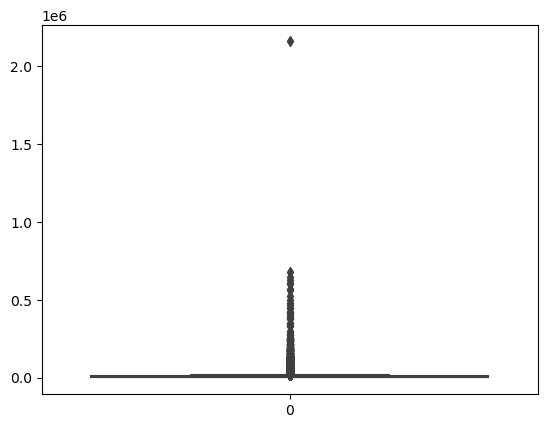

In [66]:
sns.boxplot(train_df['stats_downloads'])

Clearly it seems like the 215K download image is an outlier, so we'll take that out

<AxesSubplot:>

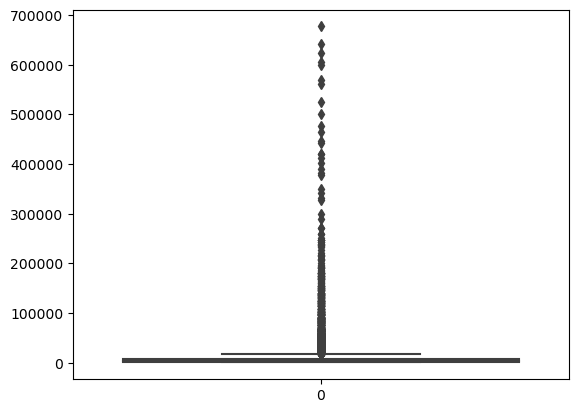

In [67]:
sns.boxplot(train_df['stats_downloads'][train_df['image_id'] !='0bfa200315'])

In [68]:
train_df_fin.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,Pristine water lily,rule of thirds photography of pink and white lotus flower floating on body of water,Canon,Canon EOS 60D,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.008150,151.0,146.0,139.0,Predicted,pond lily,99.158722,thirds
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-1570053497691-ce588b95a10a,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,NaN,sand in desert,SONY,ILCE-6500,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839,bisque,0.067400,0.468920,9.0,13864.19,2.163956,0.007673,183.0,163.0,150.0,Predicted,soil,99.999489,desert
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-1580184481884-6125224cd8d2,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,NaN,green trees near brown mountain during daytime,NIKON CORPORATION,NIKON D850,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787,dimgray,0.156467,0.463431,8.0,11015.06,2.163956,0.008315,122.0,122.0,111.0,Predicted,nature,99.871567,near
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-07e55492a09d,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,NaN,gray dock aerial photography,DJI,FC220,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049,dimgray,0.517937,0.664781,7.0,7146.05,2.302585,0.010369,139.0,126.0,121.0,Predicted,water,99.955086,dock
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-1587812080242-0010b3d77f8d,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,NaN,people walking on green grass field near lake under blue sky during daytime,FUJIFILM,X-T10,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982,steelblue,0.093867,0.170882,8.0,9143.18,2.302585,0.008537,142.0,155.0,112.0,Suggested,nature,99.912849,lake


### Preprocessing weekday

In [69]:
train_df_fin['weekday']=train_df_fin['photo_submitted_at'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d').weekday())
train_df_fin.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object,weekday
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,Pristine water lily,rule of thirds photography of pink and white lotus flower floating on body of water,Canon,Canon EOS 60D,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.008150,151.0,146.0,139.0,Predicted,pond lily,99.158722,thirds,3
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-1570053497691-ce588b95a10a,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,NaN,sand in desert,SONY,ILCE-6500,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839,bisque,0.067400,0.468920,9.0,13864.19,2.163956,0.007673,183.0,163.0,150.0,Predicted,soil,99.999489,desert,2
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-1580184481884-6125224cd8d2,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,NaN,green trees near brown mountain during daytime,NIKON CORPORATION,NIKON D850,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787,dimgray,0.156467,0.463431,8.0,11015.06,2.163956,0.008315,122.0,122.0,111.0,Predicted,nature,99.871567,near,1
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-07e55492a09d,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,NaN,gray dock aerial photography,DJI,FC220,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049,dimgray,0.517937,0.664781,7.0,7146.05,2.302585,0.010369,139.0,126.0,121.0,Predicted,water,99.955086,dock,0
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-1587812080242-0010b3d77f8d,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,NaN,people walking on green grass field near lake under blue sky during daytime,FUJIFILM,X-T10,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982,steelblue,0.093867,0.170882,8.0,9143.18,2.302585,0.008537,142.0,155.0,112.0,Suggested,nature,99.912849,lake,5


In [70]:
test_df_fin['weekday']=test_df_fin['photo_submitted_at'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d').weekday())
test_df_fin.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object,weekday
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-1570631550965-fe4e7b868d38,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,6016,0.67,NaN,brown leaf,NIKON CORPORATION,NIKON D750,100.0,4.5,50.0,1/640,NaN,NaN,NaN,NaN,1249,darkolivegreen,0.018533,0.259108,5.0,8760.15,2.302585,0.009240,158.0,133.0,116.0,Predicted,plant,99.867035,leaf,2
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-1573924429356-97a3ce13c43c,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,4160,1.50,NaN,gray seal,Canon,Canon EOS 6D Mark II,100.0,5.6,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211,gray,0.181267,0.345520,7.0,7313.21,2.163956,0.010215,139.0,136.0,125.0,Predicted,sea life,98.562889,seal,5
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3666131be6ca,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,3648,1.50,NaN,NaN,Canon,Canon EOS 6D,100.0,7.1,50.0,1/1000,NaN,NaN,NaN,NaN,1439,mediumaquamarine,0.128667,0.296128,8.0,10990.06,2.302585,0.008033,82.0,172.0,159.0,Suggested,mountain,99.946297,None,1
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-1575384543514-6cc7f8e46fd1,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,6000,0.67,NaN,landscape photography of desert,SONY,ILCE-7M2,100.0,8.0,85.0,1/200,NaN,NaN,NaN,NaN,1194,darkslategray,0.329267,0.489937,7.0,8614.56,2.302585,0.009213,131.0,131.0,131.0,Predicted,soil,99.999969,desert,1
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-385e15ea6af6,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,4000,1.50,NaN,brown grass,SONY,ILCE-6000,160.0,5.6,93.0,1/160,NaN,NaN,NaN,NaN,1457,darkgray,0.158067,0.601419,6.0,8006.92,2.163956,0.009885,125.0,116.0,105.0,Predicted,plant,99.999527,grass,4


## Preprocessing Camera_make and camera_model variables

In [71]:
train_df_fin.groupby('camera_make').agg({'stats_downloads':'sum'}).sort_values('stats_downloads', ascending=False)

,stats_downloads
camera_make,
Canon,51260387
NIKON CORPORATION,30731138
SONY,16297930
FUJIFILM,10470899
DJI,5238251
...,...
InFocus,1501
ADI,1419
MAKER NAME,1258


In [72]:
train_df_fin.groupby('camera_model').agg({'stats_downloads':'sum'}).sort_values('stats_downloads', ascending=False)

,stats_downloads
camera_model,
Canon EOS 5D Mark III,8168858
Canon EOS 6D,7651169
NIKON D750,4378278
Canon EOS 5D Mark II,3859769
NIKON D700,2969235
...,...
D3500,474
ONEPLUS A6010,461
FujiFilm X-E1,447


In [73]:
train_df_fin['camera_make']=train_df_fin['camera_make'].str.lower()
train_df_fin['camera_make'].sort_values().unique() 

array(['adi', 'apple', 'asus', 'cannon', 'canon',
       'canon, svr 90mm, 15 images', 'canon, svr90, 15 images',
       'canon, svr90mm, 11 images', 'canon, wogt71, 19 images',
       'canon, wogt71, 26 images', 'canon, wogt71, 32 images', 'dji',
       'dji mavic 2 pro', 'dji mavic pro', 'dji spark', 'doogee',
       'eastman kodak company', 'fujica', 'fujifilm', 'google', 'gopro',
       'hasselblad', 'htc', 'huawei', 'infocus', 'leaf', 'leica',
       'leica camera ag', 'lenovo', 'lg electronics', 'lge', 'maker name',
       'mamiya', 'meizu', 'motorola', 'nikon', 'nikon corporation',
       'olympus', 'olympus corporation', 'olympus imaging corp.',
       'oneplus', 'panasonic', 'parrot', 'pentax', 'pentax corporation',
       'pentax ricoh imaging', 'phase one a/s', 'ricoh',
       'ricoh imaging company, ltd.', 'samsung', 'sigma', 'sony',
       'spectre', 'vivo', 'xiaomi', 'xiaoyi', 'yi technology', 'zenit',
       'zwo', 'zwo w/ wogt71 21 frames each sho', 'zwo wogt71',
      

In [74]:
test_df_fin['camera_make']=test_df_fin['camera_make'].str.lower()
test_df_fin['camera_make'].sort_values().unique() 

array(['apple', 'asi', 'bq', 'canon', 'canon, svr90, 28 frames',
       'canon, wogt71, 10+ frames', 'dji', 'dji mavic pro',
       'fuji photo film co., ltd.', 'fujica', 'fujifilm', 'google',
       'gopro', 'hasselblad', 'htc', 'huawei', 'iphone 5',
       'konica minolta', 'leica', 'leica camera ag', 'lenovo',
       'lg electronics', 'lge', 'minolta', 'motorola', 'nikon',
       'nikon corporation', 'olympus', 'olympus corporation',
       'olympus imaging corp.', 'oneplus', 'oppo', 'panasonic', 'pentax',
       'pentax corporation', 'ricoh imaging company, ltd.', 'samsung',
       'samsung techwin co., ltd.', 'sealife', 'sigma', 'sony',
       'sony a7 iii', 'sony alpha', 'vivo', 'xiaomi', 'xiaoyi', 'zenit',
       'zwo', 'zwo w/ wogt71 20 frames each sho',
       'zwo w/wogt71 33 frames each sho', nan], dtype=object)

I plan to concat similar name companies which make logical sense for canon has multiple iterations

In [75]:
def preprocess_cameramake(data):
    data.loc[data['camera_make'].isin(['apple', 'iphone 5']),'camera_make'] = 'apple'
    data.loc[data['camera_make'].isin(['cannon', 'canon',
       'canon, svr 90mm, 15 images', 'canon, svr90, 15 images',
       'canon, svr90mm, 11 images', 'canon, wogt71, 19 images',
       'canon, wogt71, 26 images', 'canon, wogt71, 32 images','canon, svr90, 28 frames',
       'canon, wogt71, 10+ frames']),'camera_make'] = 'canon'
    data.loc[data['camera_make'].isin(['dji',
        'dji mavic 2 pro', 'dji mavic pro', 'dji spark']),'camera_make'] = 'dji'
    data.loc[data['camera_make'].isin(['fujifilm', 'fuji photo film co., ltd.']),'camera_make'] = 'fujifilm'
    data.loc[data['camera_make'].isin(['leica',
        'leica camera ag']),'camera_make']= 'leica'
    data.loc[data['camera_make'].isin(['lg electronics', 'lge']),'camera_make'] = 'lg'
    data.loc[data['camera_make'].isin(['konica minolta', 'minolta']),'camera_make'] = 'minolta'
    data.loc[data['camera_make'].isin(['nikon', 'nikon corporation']),'camera_make'] = 'nikon'
    data.loc[data['camera_make'].isin(['olympus', 'olympus corporation','olympus imaging corp.']),'camera_make'] = 'olympus'
    data.loc[data['camera_make'].isin(['pentax', 'pentax corporation','pentax ricoh imaging']),'camera_make'] = 'pentax'
    data.loc[data['camera_make'].isin(['ricoh',
        'ricoh imaging company, ltd.']),'camera_make' ]= 'ricoh'
    data.loc[data['camera_make'].isin(['samsung', 'samsung techwin co., ltd.']),'camera_make'] = 'samsung'
    data.loc[data['camera_make'].isin(['sony', 'sony a7 iii', 'sony alpha']),'camera_make'] = 'sony'
    data.loc[data['camera_make'].isin(['zwo', 'zwo w/ wogt71 21 frames each sho', 'zwo wogt71',
        'zwo, wogt71, 15 frames each of h, o, s','zwo w/ wogt71 20 frames each sho',
        'zwo w/wogt71 33 frames each sho']),'camera_make']= 'zwo'
    
    return data

In [76]:
train_df_fin=preprocess_cameramake(train_df_fin)
train_df_fin['camera_make'].sort_values().unique() 

array(['adi', 'apple', 'asus', 'canon', 'dji', 'doogee',
       'eastman kodak company', 'fujica', 'fujifilm', 'google', 'gopro',
       'hasselblad', 'htc', 'huawei', 'infocus', 'leaf', 'leica',
       'lenovo', 'lg', 'maker name', 'mamiya', 'meizu', 'motorola',
       'nikon', 'olympus', 'oneplus', 'panasonic', 'parrot', 'pentax',
       'phase one a/s', 'ricoh', 'samsung', 'sigma', 'sony', 'spectre',
       'vivo', 'xiaomi', 'xiaoyi', 'yi technology', 'zenit', 'zwo', nan],
      dtype=object)

In [77]:
test_df_fin=preprocess_cameramake(test_df_fin)
test_df_fin['camera_make'].sort_values().unique() 

array(['apple', 'asi', 'bq', 'canon', 'dji', 'fujica', 'fujifilm',
       'google', 'gopro', 'hasselblad', 'htc', 'huawei', 'leica',
       'lenovo', 'lg', 'minolta', 'motorola', 'nikon', 'olympus',
       'oneplus', 'oppo', 'panasonic', 'pentax', 'ricoh', 'samsung',
       'sealife', 'sigma', 'sony', 'vivo', 'xiaomi', 'xiaoyi', 'zenit',
       'zwo', nan], dtype=object)

In [78]:
train_df_fin.loc[train_df_fin['camera_make'].isin(['cannon', 'canon',
       'canon, svr 90mm, 15 images', 'canon, svr90, 15 images',
       'canon, svr90mm, 11 images', 'canon, wogt71, 19 images',
       'canon, wogt71, 26 images', 'canon, wogt71, 32 images']),'camera_make'] = 'canon'
train_df_fin.loc[train_df_fin['camera_make'].isin(['dji',
       'dji mavic 2 pro', 'dji mavic pro', 'dji spark']),'camera_make'] = 'dji'
train_df_fin.loc[train_df_fin['camera_make'].isin(['leica',
       'leica camera ag']),'camera_make']= 'leica'
train_df_fin.loc[train_df_fin['camera_make'].isin(['lg electronics', 'lge']),'camera_make'] = 'lg'
train_df_fin.loc[train_df_fin['camera_make'].isin(['nikon', 'nikon corporation']),'camera_make'] = 'nikon'
train_df_fin.loc[train_df_fin['camera_make'].isin(['olympus', 'olympus corporation','olympus imaging corp.']),'camera_make'] = 'olympus'
train_df_fin.loc[train_df_fin['camera_make'].isin(['pentax', 'pentax corporation','pentax ricoh imaging']),'camera_make'] = 'pentax'
train_df_fin.loc[train_df_fin['camera_make'].isin(['ricoh',
       'ricoh imaging company, ltd.']),'camera_make' ]= 'ricoh'
train_df_fin.loc[train_df_fin['camera_make'].isin(['zwo', 'zwo w/ wogt71 21 frames each sho', 'zwo wogt71',
       'zwo, wogt71, 15 frames each of h, o, s']),'camera_make']= 'zwo'

train_df_fin['camera_make'].sort_values().unique() 

array(['adi', 'apple', 'asus', 'canon', 'dji', 'doogee',
       'eastman kodak company', 'fujica', 'fujifilm', 'google', 'gopro',
       'hasselblad', 'htc', 'huawei', 'infocus', 'leaf', 'leica',
       'lenovo', 'lg', 'maker name', 'mamiya', 'meizu', 'motorola',
       'nikon', 'olympus', 'oneplus', 'panasonic', 'parrot', 'pentax',
       'phase one a/s', 'ricoh', 'samsung', 'sigma', 'sony', 'spectre',
       'vivo', 'xiaomi', 'xiaoyi', 'yi technology', 'zenit', 'zwo', nan],
      dtype=object)

In [79]:
train_df_fin['camera_model'].sort_values().unique()

array(['11', '1100D', '1300D', '183MC', '500D', '5500', '5D Mark III',
       '6300', '6D Mark II', '80D', '96660', 'A 6000', 'A6000', 'A6300',
       'A6400', 'A7', 'A7 III', 'A7 ii', 'A7R III', 'A7R3', 'A7RII',
       'A7RIII', 'A7RIV', 'A7iii', 'A7rii', 'A7s', 'ANE-LX1',
       'ASI1600MM  Pro', 'ASI1600MM Pro', 'ASI294MC-Pro', 'Alpha 6000',
       'Alpha 7S', 'Alpha A7 III', 'Alpha A7rii', 'Alpha A7s',
       'Alpha SLT-A58', 'Alpha a7', 'Alpha a7R', 'Anafi',
       'Asus Zenfone 5', 'BL7000', 'BLN-L21', 'C8080WZ', 'CLT-L29',
       'COOLPIX A', 'COOLPIX AW110', 'COOLPIX AW120', 'COOLPIX B700',
       'COOLPIX L11', 'COOLPIX L120', 'COOLPIX L330', 'COOLPIX L810',
       'COOLPIX L830', 'COOLPIX P1000', 'COOLPIX P300', 'COOLPIX P510',
       'COOLPIX P520', 'COOLPIX P610', 'COOLPIX S9700', 'Cannon t5',
       'Canon 5d Mark IV', 'Canon A-1', 'Canon EOS 1000D',
       'Canon EOS 100D', 'Canon EOS 10D', 'Canon EOS 1100D',
       'Canon EOS 1200D', 'Canon EOS 1300D', 'Canon EOS 1500D',

In [80]:
train[train.camera_model.isnull()].shape

(48, 26)

In [81]:
both=train_df_fin[(train_df_fin.camera_make.isnull()) & (train_df_fin.camera_model.isnull()) ].shape[0]
cmodel=train_df_fin[(train_df_fin.camera_make.isnull()) & (train_df_fin.camera_model.notnull()) ].shape[0]
cmake=train_df_fin[(train_df_fin.camera_make.notnull()) & (train_df_fin.camera_model.isnull()) ].shape[0]

print('both camera make & model null: ',both,'camera model not null: ',cmodel,'camera make not null: ',cmake)

both camera make & model null:  29 camera model not null:  11 camera make not null:  19


In [82]:
train_df_fin[(train_df_fin.camera_make.isnull()) & (train_df_fin.camera_model.notnull())].head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object,weekday
452,eca7e87d03,https://unsplash.com/photos/DtM_-KOTUVo,https://images.unsplash.com/photo-1552635114-3eb88475121c,2019-03-15 07:36:08.401809,Friday,7,36,8,Featured,5300,5300,1.00,Let us meet at the sign — but don´t let me white too long.,white and brown trees,NaN,E-M1,200.0,8.0,21.0,23,48.248312,16.265615,Austria,Wien,1457,1606,silver,0.335556,0.383934,6.0,12251.18,2.025326,0.007920,154.0,142.0,152.0,Predicted,nature,99.670662,trees,4
1071,bee68f9815,https://unsplash.com/photos/Fx9O8zKfz9w,https://images.unsplash.com/photo-1436377793074-e85196f02c35,2015-07-08 17:49:18.795253,Wednesday,17,49,18,Featured,4928,3072,1.60,NaN,aerial photography of city under gray clouds,NaN,NIKON D5100,400.0,10.0,8.0,1/1250,NaN,NaN,NaN,NaN,2803,7605,darkslategray,0.539819,0.222594,6.0,10816.05,2.302585,0.008379,128.0,134.0,126.0,Predicted,landscape,87.717842,city,2
1855,5e15dcf061,https://unsplash.com/photos/z_6048wbVio,https://images.unsplash.com/photo-1544415595-e38016facd98,2018-12-10 04:20:05.935974,Monday,4,20,5,Featured,5184,2684,1.93,Over the Clouds,mountain cover with snow photography,NaN,Canon EOS REBEL T2i,100.0,5.0,45.0,1/15,NaN,NaN,NaN,NaN,1552,7131,lightpink,0.126838,0.417191,9.0,9483.66,2.302585,0.009356,180.0,150.0,180.0,Predicted,nature,99.890388,cover,0
3298,efd3bf77ec,https://unsplash.com/photos/F5ypWjjulqw,https://images.unsplash.com/photo-1570988769432-b3b3b6ac98de,2019-10-13 17:48:28.453961,Sunday,17,48,28,Featured,6133,4595,1.33,"Rainbow Lorikeet, a very common bird in Australia, it is very aggressive feeder and somewhat of a bully to other birds, but its colourful plumage usually makes it welcome in most backyards.",lorikeet on pink flower,NaN,NIKON D850,2500.0,5.6,500.0,1/1250,-35.103611,150.626667,Australia,Sanctuary Point,1245,4253,darkgreen,0.033095,0.186229,8.0,17079.73,2.302585,0.006233,101.0,104.0,75.0,Suggested,bird,98.964630,lorikeet,6
3816,63cd2598c2,https://unsplash.com/photos/oWHNeo9C8hY,https://images.unsplash.com/photo-1564052564443-b2bda4494a1f,2019-07-25 11:07:25.355662,Thursday,11,7,25,Featured,8256,5504,1.50,"Jervis Bay Bioluminescence Bioluminescence is the production and emission of light by a living organism, in this case algae that when disturbed glows blue. This occurs at various but limited locations around the world.",calm water,NaN,NIKON D850,1250.0,3.2,15.0,15,-35.070915,150.696998,Australia,Huskisson,1325,2518,dodgerblue,0.124000,0.422275,7.0,12011.11,2.163956,0.008005,63.0,141.0,203.0,Predicted,water,99.953537,calm,3


In [83]:
train_df_fin[(train_df_fin.camera_make.isnull()) & (train_df_fin.camera_model.notnull())]['camera_model'].str.split().str[0]


452           E-M1
1071         NIKON
1855         Canon
3298         NIKON
3816         NIKON
4808         NIKON
6299         Canon
7333     DSC-HX50V
7630          E-M1
7963    E-M1MarkII
8902         SIGMA
Name: camera_model, dtype: object

In [84]:
train_df_fin[(train_df_fin.camera_make.notnull()) & (train_df_fin.camera_model.isnull()) ].head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object,weekday
676,9a12bb8fe9,https://unsplash.com/photos/SQt0ZDqNapg,https://images.unsplash.com/photo-1552478099-e4c486e8d4c4,2019-03-13 11:55:56.485794,Wednesday,11,55,56,Featured,3992,2992,1.33,Wild Blues 🌊,bird's-eye photography of body of water,dji,NaN,200.0,2.2,4.79,1/80,NaN,NaN,NaN,NaN,1459,2977,cadetblue,0.216250,0.423342,6.0,4868.210000,2.302585,0.012438,39.0,116.0,121.0,Predicted,water,99.717010,birdseye,2
2612,63c0ba214e,https://unsplash.com/photos/LPKk3wtkC-g,https://images.unsplash.com/photo-1511207538754-e8555f2bc187,2017-11-20 19:52:50.441594,Monday,19,52,50,Featured,2412,4288,0.56,NaN,scenery of forest trees,nikon,NaN,160.0,3.5,50.00,1/250,NaN,NaN,NaN,NaN,1937,167386,darkslategray,0.997063,0.714390,5.0,6545.975309,2.043192,0.011081,69.0,91.0,85.0,Predicted,sea,92.744972,scenery,0
2737,90bd79188c,https://unsplash.com/photos/XXX5HKsq4e0,https://images.unsplash.com/photo-1560804507-6dd8846d14eb,2019-06-17 20:48:44.821429,Monday,20,48,44,Featured,4004,2669,1.50,NaN,brown antelope,canon,NaN,1000.0,5.6,400.00,1/200,NaN,NaN,Netherlands,NaN,1363,2911,gray,0.235067,0.429713,6.0,4200.980000,2.302585,0.013120,100.0,133.0,104.0,Predicted,mammal,99.833794,antelope,0
3064,f01a1db988,https://unsplash.com/photos/xpVh9nbRcWw,https://images.unsplash.com/photo-1563663170139-88d80d6387ac,2019-07-20 22:53:29.669679,Saturday,22,53,29,Featured,2872,3588,0.80,"Multnomah Falls, Oregon",waterfalls photo,spectre,NaN,25.0,1.8,4.20,9,45.576833,-122.116208,United States,Cascade Locks,1329,4000,darkslategray,0.392000,0.310686,6.0,6062.810000,2.163956,0.011107,95.0,115.0,85.0,Suggested,nature,99.879692,waterfalls,5
4731,93e62909ff,https://unsplash.com/photos/ELoa8cRyLiQ,https://images.unsplash.com/photo-1546632958-f0a7001a5ed6,2019-01-04 20:16:31.792797,Friday,20,16,31,Featured,7243,4829,1.50,NaN,sea during golden hour,nikon,NaN,500.0,3.2,130.00,1/8000,NaN,NaN,NaN,NaN,1527,11595,sandybrown,0.040200,0.271460,7.0,8636.730000,2.302585,0.009181,201.0,148.0,77.0,Predicted,flare,99.996056,hour,4


In [85]:
train_df_fin.groupby('camera_make').agg({'stats_downloads':'sum'}).sort_values('stats_downloads', ascending=False).head()

,stats_downloads
camera_make,
canon,51312184
nikon,31380155
sony,16880091
fujifilm,10667618
dji,5270994


I'm leaving filling missing values for camera make and model right now as it might be too personalized. We can fill in for camera make atleast as the camera model is populating with company name majority of the times but for camera_model there is no way to guess the model as of now

In [86]:
train_df_fin.head(1)

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,image_classification,classification_keyword,confidence_value,image_object,weekday
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.5,Pristine water lily,rule of thirds photography of pink and white lotus flower floating on body of water,canon,Canon EOS 60D,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.00815,151.0,146.0,139.0,Predicted,pond lily,99.158722,thirds,3


## Columns Drop

In [87]:
# Dropping some variables which won't be required for modelling
drop_cols=['photo_submitted_at','obs_day','description1','description2',
           'latitude','longitude','country','city','image_classification','confidence_value'
           ]
print('Dropping columns: ',drop_cols, 'current shape: ',train_df_fin.shape)
train_df_fin.drop(drop_cols, axis=1, inplace=True)
print('columns are dropped final shape:',train_df_fin.shape)

Dropping columns:  ['photo_submitted_at', 'obs_day', 'description1', 'description2', 'latitude', 'longitude', 'country', 'city', 'image_classification', 'confidence_value'] current shape:  (12197, 41)
columns are dropped final shape: (12197, 31)


In [88]:
print('Dropping columns: ',drop_cols, 'current shape: ',test_df_fin.shape)
test_df_fin.drop(drop_cols, axis=1, inplace=True)
print('columns are dropped final shape:',test_df_fin.shape)

Dropping columns:  ['photo_submitted_at', 'obs_day', 'description1', 'description2', 'latitude', 'longitude', 'country', 'city', 'image_classification', 'confidence_value'] current shape:  (6568, 40)
columns are dropped final shape: (6568, 30)


## Working on correcting exposure time

In [89]:
train_df_fin.head(1)

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,15,13,10,Featured,2592,1728,1.5,canon,Canon EOS 60D,200.0,14.0,50.0,1/60,2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.00815,151.0,146.0,139.0,pond lily,thirds,3


In [90]:
# to_number = lambda x: float(1) / float(x.split('/')[1]) if isinstance(x, str) and '/' in x else float(x) if isinstance(x, str) else np.nan

def to_float(x):
    if isinstance(x, str):
        if '/' in x:
            if 's' in x:
                x = x[:-1]
            return float(1) / float(x.split('/')[1])
        elif 's' in x:
            if ' ' in x:
                x = x.split(' ')[0]
                return float(x)
            else:
                return float(x[:-1])
        elif 'h' in x:
            return float(x[:-1]) * 60 * 60
        elif '"' in x:
            return float(x[:-1])
        else:
            return float(x)
    else:
        return np.nan


In [91]:
train_df_fin['exposure_time'] = train_df_fin['exposure_time'].apply(to_float)
train_df_fin.head(1)

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,15,13,10,Featured,2592,1728,1.5,canon,Canon EOS 60D,200.0,14.0,50.0,0.016667,2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.00815,151.0,146.0,139.0,pond lily,thirds,3


In [92]:
test_df_fin['exposure_time'] = test_df_fin['exposure_time'].apply(to_float)
test_df_fin.head(1)

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-1570631550965-fe4e7b868d38,14,32,57,Featured,4016,6016,0.67,nikon,NIKON D750,100.0,4.5,50.0,0.001563,1249,darkolivegreen,0.018533,0.259108,5.0,8760.15,2.302585,0.00924,158.0,133.0,116.0,plant,leaf,2


In [93]:
# test_df_fin[test_df_fin['exposure_time']=='63 Seconds'].head()

In [94]:
# test_df_fin.exposure_time.sort_values().unique()

In [95]:
# train_df_fin.exposure_time.unique()

In [96]:
train_df_fin.loc[train_df_fin['exposure_time']=='1/80s'] #exceptional value

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday


In [97]:
train_df_fin[train_df_fin['exposure_time']==' 80s']['exposure_time']
# train_df_fin[train_df_fin['exposure_time'].str.contains('s')]


Series([], Name: exposure_time, dtype: float64)

In [98]:
# getimage('e912a54a19',train_df_fin) #image with 2 hrs exposure time

### Exposure time is also done

In [99]:
train_df_fin.head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,15,13,10,Featured,2592,1728,1.50,canon,Canon EOS 60D,200.0,14.0,50.0,0.016667,2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.008150,151.0,146.0,139.0,pond lily,thirds,3
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-1570053497691-ce588b95a10a,21,59,51,Featured,4000,6000,0.67,sony,ILCE-6500,100.0,2.5,30.0,0.000800,1255,1839,bisque,0.067400,0.468920,9.0,13864.19,2.163956,0.007673,183.0,163.0,150.0,soil,desert,2
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-1580184481884-6125224cd8d2,4,10,11,Featured,5504,8256,0.67,nikon,NIKON D850,64.0,2.8,48.0,0.000625,1138,787,dimgray,0.156467,0.463431,8.0,11015.06,2.163956,0.008315,122.0,122.0,111.0,nature,near,1
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-07e55492a09d,23,46,21,Featured,3627,2040,1.78,dji,FC220,139.0,2.2,4.7,0.010000,1579,2049,dimgray,0.517937,0.664781,7.0,7146.05,2.302585,0.010369,139.0,126.0,121.0,water,dock,0
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-1587812080242-0010b3d77f8d,11,4,20,Featured,4896,3264,1.50,fujifilm,X-T10,400.0,6.4,22.2,0.002381,1050,2982,steelblue,0.093867,0.170882,8.0,9143.18,2.302585,0.008537,142.0,155.0,112.0,nature,lake,5


In [100]:
summary(train_df_fin)

data shape: (12197, 31)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.000000,12197,NaN,NaN,68105c019b,06d11c4edd,f6599edba1
photo_url,object,0,0.000000,12197,NaN,NaN,https://unsplash.com/photos/7AcMUSYRZpU,https://unsplash.com/photos/grWwLCSRr4o,https://unsplash.com/photos/OR4q9_Y2nuY
photo_image_url,object,0,0.000000,12197,NaN,NaN,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,https://images.unsplash.com/photo-1570053497691-ce588b95a10a,https://images.unsplash.com/photo-1580184481884-6125224cd8d2
obs_hour,int64,0,0.000000,24,0.0,23.0,15,21,4
obs_min,int64,0,0.000000,60,0.0,59.0,13,59,10
obs_sec,int64,0,0.000000,60,0.0,59.0,10,51,11
image_category,object,0,0.000000,2,NaN,NaN,Featured,Featured,Featured
width,int64,0,0.000000,2792,1275.0,16384.0,2592,4000,5504
height,int64,0,0.000000,2894,774.0,14850.0,1728,6000,8256
aspect_ratio,float64,0,0.000000,171,0.34,3.95,1.5,0.67,0.67


Need to figure out encoding for camera_make,camera_model,dominant_clr and classification_keyword variables

- Can apply target encoding to camera_make, camera_model, classification keyword, dominant_clr and label encode image_category


## Label encoding image_category

In [101]:
label_encoder = LabelEncoder()
train_df_fin['image_category'] = label_encoder.fit_transform(train_df_fin['image_category'])

In [102]:
test_df_fin['image_category'] = label_encoder.transform(test_df_fin['image_category'])

In [103]:
train_df_fin.head(1)

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,15,13,10,0,2592,1728,1.5,canon,Canon EOS 60D,200.0,14.0,50.0,0.016667,2361,167503,thistle,0.054467,0.313672,8.0,12271.86,2.302585,0.00815,151.0,146.0,139.0,pond lily,thirds,3


In [104]:
train_df_fin[train_df_fin.image_id=='0bfa200315']

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
9559,0bfa200315,https://unsplash.com/photos/yN9l6LJVBIU,https://images.unsplash.com/photo-1573969624747-617e29238f63,5,48,42,0,2589,4255,0.61,nikon,NIKON D700,100.0,8.0,18.0,0.01,1210,2154381,linen,0.338169,0.254702,9.0,14679.57,2.302585,0.007069,146.0,141.0,97.0,arecaceae,lowangle,6


In [105]:
# As discussed in outlier analysis, we will remove the image '0bfa200315' from the training data set, as it seems to be an outlier
print('Shape before removing the outlier image: ',train_df_fin.shape)
train_df_fin = train_df_fin[train_df_fin['image_id'] != '0bfa200315']
print('Shape after removing the outlier image: ',train_df_fin.shape)

Shape before removing the outlier image:  (12197, 31)
Shape after removing the outlier image:  (12196, 31)


## Target Encoding

In [106]:
me = MEstimateEncoder(cols=['camera_make', 'camera_model', 'classification_keyword','dominant_clr','image_object'], 
                      handle_unknown='value', 
                      handle_missing='value', 
                      m=5.0, 
                      sigma=0.1,
                      randomized=True,
                      random_state=42)

In [107]:
# target_encoder = ce.TargetEncoder(cols=['camera_make', 'camera_model', 'classification_keyword','dominant_clr'],handle_missing='value',handle_unknown='value')
df_encoded = me.fit_transform(train_df_fin.drop(columns=['stats_downloads']), train_df_fin['stats_downloads'])

# Merge the encoded features with the target variable
train_df_encoded = pd.concat([df_encoded, train_df_fin['stats_downloads']], axis=1)
train_df_encoded.head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday,stats_downloads
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,15,13,10,0,2592,1728,1.50,11068.726566,17643.711722,200.0,14.0,50.0,0.016667,2361,13220.173904,0.054467,0.313672,8.0,12271.86,2.302585,0.008150,151.0,146.0,139.0,33614.001361,28216.274654,3,167503
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-1570053497691-ce588b95a10a,21,59,51,0,4000,6000,0.67,8098.068287,7161.173033,100.0,2.5,30.0,0.000800,1255,5769.309806,0.067400,0.468920,9.0,13864.19,2.163956,0.007673,183.0,163.0,150.0,6487.978012,20557.738821,2,1839
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-1580184481884-6125224cd8d2,4,10,11,0,5504,8256,0.67,11768.334038,4341.129100,64.0,2.8,48.0,0.000625,1138,9714.061065,0.156467,0.463431,8.0,11015.06,2.163956,0.008315,122.0,122.0,111.0,8518.320284,16064.021692,1,787
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-07e55492a09d,23,46,21,0,3627,2040,1.78,13363.786156,10555.881614,139.0,2.2,4.7,0.010000,1579,10512.649321,0.517937,0.664781,7.0,7146.05,2.302585,0.010369,139.0,126.0,121.0,11704.391563,9836.806961,0,2049
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-1587812080242-0010b3d77f8d,11,4,20,0,4896,3264,1.50,12173.079547,10049.266507,400.0,6.4,22.2,0.002381,1050,12159.302985,0.093867,0.170882,8.0,9143.18,2.302585,0.008537,142.0,155.0,112.0,7812.832720,18011.873822,5,2982


In [108]:
test_df_encoded = me.transform(test_df_fin)
test_df_encoded.head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-1570631550965-fe4e7b868d38,14,32,57,0,4016,6016,0.67,11052.477724,10966.627455,100.0,4.5,50.0,0.001563,1249,8714.739792,0.018533,0.259108,5.0,8760.15,2.302585,0.009240,158.0,133.0,116.0,6227.773248,18480.613818,2
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-1573924429356-97a3ce13c43c,17,15,26,0,6240,4160,1.50,10544.944260,5313.425967,100.0,5.6,300.0,0.005000,1211,7438.412798,0.181267,0.345520,7.0,7313.21,2.163956,0.010215,139.0,136.0,125.0,9973.343645,8074.037818,5
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3666131be6ca,6,54,42,0,5472,3648,1.50,10544.944260,8734.023233,100.0,7.1,50.0,0.001000,1439,11744.499240,0.128667,0.296128,8.0,10990.06,2.302585,0.008033,82.0,172.0,159.0,12436.662190,5482.065870,1
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-1575384543514-6cc7f8e46fd1,14,49,46,0,4000,6000,0.67,8211.605476,6977.781820,100.0,8.0,85.0,0.005000,1194,11196.803642,0.329267,0.489937,7.0,8614.56,2.302585,0.009213,131.0,131.0,131.0,6578.941284,20845.964087,1
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-385e15ea6af6,1,32,29,0,6000,4000,1.50,8211.605476,9622.033003,160.0,5.6,93.0,0.006250,1457,6969.131116,0.158067,0.601419,6.0,8006.92,2.163956,0.009885,125.0,116.0,105.0,6227.773248,10001.072446,4


In [109]:
summary(train_df_encoded)

data shape: (12196, 31)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.000000,12196,NaN,NaN,68105c019b,06d11c4edd,f6599edba1
photo_url,object,0,0.000000,12196,NaN,NaN,https://unsplash.com/photos/7AcMUSYRZpU,https://unsplash.com/photos/grWwLCSRr4o,https://unsplash.com/photos/OR4q9_Y2nuY
photo_image_url,object,0,0.000000,12196,NaN,NaN,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,https://images.unsplash.com/photo-1570053497691-ce588b95a10a,https://images.unsplash.com/photo-1580184481884-6125224cd8d2
obs_hour,int64,0,0.000000,24,0.0,23.0,15,21,4
obs_min,int64,0,0.000000,60,0.0,59.0,13,59,10
obs_sec,int64,0,0.000000,60,0.0,59.0,10,51,11
image_category,int64,0,0.000000,2,0.0,1.0,0,0,0
width,int64,0,0.000000,2791,1275.0,16384.0,2592,4000,5504
height,int64,0,0.000000,2893,774.0,14850.0,1728,6000,8256
aspect_ratio,float64,0,0.000000,171,0.34,3.95,1.5,0.67,0.67


In [110]:
summary(test_df_encoded)

data shape: (6568, 30)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.000000,6568,NaN,NaN,2322208d63,847b5fcee1,0e1a37b065
photo_url,object,0,0.000000,6568,NaN,NaN,https://unsplash.com/photos/FuX1NIv8lLk,https://unsplash.com/photos/t5rBtxLiHj8,https://unsplash.com/photos/9jdlJzl6yN8
photo_image_url,object,0,0.000000,6568,NaN,NaN,https://images.unsplash.com/photo-1570631550965-fe4e7b868d38,https://images.unsplash.com/photo-1573924429356-97a3ce13c43c,https://images.unsplash.com/photo-1554188068-3666131be6ca
obs_hour,int64,0,0.000000,24,0.0,23.0,14,17,6
obs_min,int64,0,0.000000,60,0.0,59.0,32,15,54
obs_sec,int64,0,0.000000,60,0.0,59.0,57,26,42
image_category,int64,0,0.000000,2,0.0,1.0,0,0,0
width,int64,0,0.000000,1907,1280.0,12349.0,4016,6240,5472
height,int64,0,0.000000,1993,697.0,12247.0,6016,4160,3648
aspect_ratio,float64,0,0.000000,144,0.55,2.87,0.67,1.5,1.5


## Overall missing values
just checking how many rows with atleast one variable missing in train, cannot drop these values as test would also have similar values and in that case we would eventually need to make a prediction

In [111]:
train_df_fin[(train_df_fin.exposure_time.isnull()) | train_df_fin.iso.isnull() | train_df_fin.camera_make.isnull() | train_df_fin.camera_model.isnull() | train_df_fin.dominant_clr.isnull()].shape

(143, 31)

In [112]:
print('Missing percentage:',(143/12196)*100)

Missing percentage: 1.1725155788783208


In [113]:
train_df_fin[train_df_fin.iso.isnull()].head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
44,94bacd1aaa,https://unsplash.com/photos/rZ1ljQA0uVI,https://images.unsplash.com/photo-1558638324-fa4d99a924e7,19,5,41,0,3456,5184,0.67,canon,Canon EOS 700D,NaN,1.8,50.0,0.005000,1388,644,rosybrown,0.083133,0.145622,9.0,11277.71,2.302585,0.008005,153.0,126.0,114.0,plant,pinkpetlaed,3
58,d2d7dc7e20,https://unsplash.com/photos/IYvdGTWXxRM,https://images.unsplash.com/photo-1570041544732-7690bf144593,18,39,37,0,2885,1826,1.58,canon,EOS 300D,NaN,7.5,600.0,NaN,1256,2917,darkslateblue,0.099368,0.469446,7.0,4480.21,2.163956,0.013016,97.0,111.0,162.0,nature,shining,2
587,e77d61358b,https://unsplash.com/photos/XW5BbnQ1I5w,https://images.unsplash.com/photo-1542318421-1d7619edc046,21,49,13,0,5184,3456,1.50,canon,Canon EOS 7D,NaN,5.6,113.0,0.006250,1576,76599,steelblue,0.130933,0.185329,7.0,6351.41,2.302585,0.010305,122.0,125.0,101.0,plant,yellow,3
1207,4a9562e7eb,https://unsplash.com/photos/8HuPjWW_kp8,https://images.unsplash.com/photo-1579197708675-52ebac41f16a,18,5,39,0,3276,4096,0.80,canon,Canon EOS 5D Mark III,NaN,2.5,50.0,0.003125,1150,658,dimgray,0.189167,0.214420,8.0,17483.34,2.302585,0.006640,127.0,114.0,97.0,apparel,flowering,3
1839,6f049653b4,https://unsplash.com/photos/_Q4mepyyjMw,https://images.unsplash.com/photo-1562555580-e60808e1d58c,3,13,6,0,3024,4032,0.75,apple,iPhone 6s Plus,NaN,2.2,4.2,0.006250,1342,3581,silver,0.196696,0.289446,9.0,8978.99,2.302585,0.009119,185.0,155.0,136.0,nature,snowcovered,0


In [114]:
test_df_fin[test_df_fin.iso.isnull()].head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
225,e93904050f,https://unsplash.com/photos/dGIfygn2_DI,https://images.unsplash.com/photo-1552472947-2abd68d0d927,13,2,49,0,2176,3244,0.67,sony,DSLR-A330,NaN,8.0,18.0,0.016667,1459,darkslategray,0.189307,0.377033,7.0,14269.41,2.302585,0.007521,97.0,110.0,89.0,tree,pipe,2
622,34356d2c67,https://unsplash.com/photos/RDs0THr4lGs,https://images.unsplash.com/photo-1481930079977-24a345fcae85,23,16,5,0,9632,3872,2.49,samsung,SM-G930F,NaN,1.7,4.2,NaN,2275,lightgray,0.189778,0.285905,7.0,5840.69,2.302585,0.011127,146.0,161.0,180.0,mountain,panoramic,4
654,80e00f9637,https://unsplash.com/photos/nKav_re96FA,https://images.unsplash.com/photo-1579715162093-ebde3f3ab5cb,17,46,30,0,4000,5510,0.73,olympus,OMD EM5 ii,NaN,1.8,25.0,NaN,1144,black,0.319083,0.282947,7.0,9936.66,2.302585,0.008969,97.0,69.0,64.0,human,camel,2
660,a301b05c9d,https://unsplash.com/photos/U7jr4ZE7reQ,https://images.unsplash.com/flagged/photo-1551706646-9c816bfbff8c,13,37,58,0,4640,3480,1.33,NaN,NaN,NaN,2.0,4.3,0.006623,1468,burlywood,0.030442,0.347556,8.0,6996.46,2.302585,0.010656,185.0,168.0,116.0,nature,erupting,0
1314,ec70c60559,https://unsplash.com/photos/P8gh-GR0dDs,https://images.unsplash.com/photo-1564198879220-63f2734f7cec,3,43,53,0,6095,4142,1.47,zwo,ASI294MC-Pro,NaN,7.5,952.0,NaN,1323,darkslategray,0.049150,0.481772,3.0,3968.59,2.163956,0.013517,60.0,104.0,129.0,nature,galaxy,5


In [115]:
train_df_fin[train_df_fin.exposure_time.isnull()].head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
58,d2d7dc7e20,https://unsplash.com/photos/IYvdGTWXxRM,https://images.unsplash.com/photo-1570041544732-7690bf144593,18,39,37,0,2885,1826,1.58,canon,EOS 300D,NaN,7.5,600.0,NaN,1256,2917,darkslateblue,0.099368,0.469446,7.0,4480.21,2.163956,0.013016,97.0,111.0,162.0,nature,shining,2
730,34eb1f0c49,https://unsplash.com/photos/YM6wO9chE2A,https://images.unsplash.com/photo-1547309300-a4aca04f6d84,16,9,9,0,5118,3411,1.50,canon,Canon EOS 70D,200.0,14.0,22.0,NaN,1519,1438,dimgray,0.135600,0.382979,8.0,7302.74,2.302585,0.009866,131.0,119.0,103.0,nature,view,5
2455,c7f4821499,https://unsplash.com/photos/uGT_K29PAjE,https://images.unsplash.com/photo-1448457632809-3224b43fe078,13,31,1,0,3494,2321,1.51,canon,Canon EOS 20D,100.0,5.6,18.0,NaN,2663,4212,darkgray,0.137333,0.383447,8.0,4039.69,2.302585,0.012701,134.0,141.0,150.0,conifer,house,2
2618,e68d802b2f,https://unsplash.com/photos/jBV3_PRk1-U,https://images.unsplash.com/photo-1568006744429-073723fadb50,5,26,36,0,5304,7952,0.67,sony,A7R3,NaN,2.8,90.0,NaN,1279,1319,darkslategray,0.149400,0.516023,4.0,8458.59,1.643418,0.010251,68.0,84.0,69.0,plant,fan,0
2718,7f96ddd4ba,https://unsplash.com/photos/32LuMRgCaTI,https://images.unsplash.com/photo-1555605374-7af91e4d0fe4,16,38,31,0,3980,5970,0.67,nikon,D7100,200.0,2.8,50.0,NaN,1423,1928,rosybrown,0.010267,0.155356,7.0,12546.76,2.163956,0.007813,130.0,106.0,89.0,ground,bluepetaled,3


In [116]:
test_df_fin[test_df_fin.exposure_time.isnull()].head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
622,34356d2c67,https://unsplash.com/photos/RDs0THr4lGs,https://images.unsplash.com/photo-1481930079977-24a345fcae85,23,16,5,0,9632,3872,2.49,samsung,SM-G930F,NaN,1.7,4.2,NaN,2275,lightgray,0.189778,0.285905,7.0,5840.69,2.302585,0.011127,146.0,161.0,180.0,mountain,panoramic,4
654,80e00f9637,https://unsplash.com/photos/nKav_re96FA,https://images.unsplash.com/photo-1579715162093-ebde3f3ab5cb,17,46,30,0,4000,5510,0.73,olympus,OMD EM5 ii,NaN,1.8,25.0,NaN,1144,black,0.319083,0.282947,7.0,9936.66,2.302585,0.008969,97.0,69.0,64.0,human,camel,2
1314,ec70c60559,https://unsplash.com/photos/P8gh-GR0dDs,https://images.unsplash.com/photo-1564198879220-63f2734f7cec,3,43,53,0,6095,4142,1.47,zwo,ASI294MC-Pro,NaN,7.5,952.0,NaN,1323,darkslategray,0.049150,0.481772,3.0,3968.59,2.163956,0.013517,60.0,104.0,129.0,nature,galaxy,5
1373,1be715c478,https://unsplash.com/photos/Aae5ozmFb_s,https://images.unsplash.com/photo-1584539329415-06b272151e73,13,49,26,0,5921,3947,1.50,sony,a6000,NaN,1.4,30.0,NaN,1088,darkslategray,0.167867,0.185079,7.0,13759.57,2.302585,0.007685,127.0,99.0,89.0,sunlight,shorts,2
1477,57937b8a33,https://unsplash.com/photos/9Ci0VKjx3Hk,https://images.unsplash.com/photo-1429552097216-d1944f46d443,17,48,17,0,4893,3226,1.52,nikon,NIKON D5100,800.0,8.0,40.0,NaN,2882,darkseagreen,0.109428,0.152303,8.0,14016.13,2.302585,0.007252,113.0,147.0,109.0,flora,shallow,0


In [117]:
# getimage('c7f4821499',train_df_fin)

In [118]:
test_df_fin[test_df_fin.camera_make.isnull()].head(1)

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
104,1e004d417a,https://unsplash.com/photos/iKSEj1JuJVo,https://images.unsplash.com/photo-1551439304-cd4d8838e973,11,22,1,0,2734,4096,0.67,NaN,NaN,50.0,2.8,20.0,0.00025,1471,darkolivegreen,0.043533,0.231378,9.0,4457.63,2.302585,0.012438,139.0,120.0,71.0,field,walking,4


In [119]:
test_df_encoded[test_df_encoded.image_id=='cba2277d11'].head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
1934,cba2277d11,https://unsplash.com/photos/hSY4lkFR_E0,https://images.unsplash.com/photo-1517206771387-88a0ebd29880,6,20,27,0,3060,1933,1.58,10447.898327,10447.898327,100.0,2.0,3.8,0.000673,1867,11196.803642,0.037825,0.161212,7.0,14597.26,2.025326,0.007207,123.0,118.0,107.0,6950.249164,5613.957636,0


In [120]:
test_df_encoded[test_df_encoded.image_id=='1e004d417a'].head()

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
104,1e004d417a,https://unsplash.com/photos/iKSEj1JuJVo,https://images.unsplash.com/photo-1551439304-cd4d8838e973,11,22,1,0,2734,4096,0.67,12727.410925,10285.61305,50.0,2.8,20.0,0.00025,1471,8714.739792,0.043533,0.231378,9.0,4457.63,2.302585,0.012438,139.0,120.0,71.0,15850.410925,6127.939665,4


In [121]:
# getimage('cba2277d11',test_df_encoded)

## Working on missing value imputation for iso,exporsure time and color related variables

In [122]:
cols_to_impute = ['exposure_time', 'iso', 'aperture_value', 'pixel_coverage', 'color_score','color_cnt','variance','entropy','similarity','dominant_color_R','dominant_color_G','dominant_color_B']

imputer = KNNImputer(n_neighbors=3)

train_df_encoded[cols_to_impute] = imputer.fit_transform(train_df_encoded[cols_to_impute])
test_df_encoded[cols_to_impute] = imputer.transform(test_df_encoded[cols_to_impute])

In [123]:
train_df_encoded[train_df_encoded['image_id']=='c7f4821499']

,image_id,photo_url,photo_image_url,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday,stats_downloads
2455,c7f4821499,https://unsplash.com/photos/uGT_K29PAjE,https://images.unsplash.com/photo-1448457632809-3224b43fe078,13,31,1,0,3494,2321,1.51,12113.237041,13934.858153,100.0,5.6,18.0,0.004163,2663,8005.612462,0.137333,0.383447,8.0,4039.69,2.302585,0.012701,134.0,141.0,150.0,12330.005486,6219.133762,2,4212


In [124]:
summary(train_df_encoded)

data shape: (12196, 31)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.0,12196,NaN,NaN,68105c019b,06d11c4edd,f6599edba1
photo_url,object,0,0.0,12196,NaN,NaN,https://unsplash.com/photos/7AcMUSYRZpU,https://unsplash.com/photos/grWwLCSRr4o,https://unsplash.com/photos/OR4q9_Y2nuY
photo_image_url,object,0,0.0,12196,NaN,NaN,https://images.unsplash.com/photo-1474557157379-8aa74a6ef541,https://images.unsplash.com/photo-1570053497691-ce588b95a10a,https://images.unsplash.com/photo-1580184481884-6125224cd8d2
obs_hour,int64,0,0.0,24,0.0,23.0,15,21,4
obs_min,int64,0,0.0,60,0.0,59.0,13,59,10
obs_sec,int64,0,0.0,60,0.0,59.0,10,51,11
image_category,int64,0,0.0,2,0.0,1.0,0,0,0
width,int64,0,0.0,2791,1275.0,16384.0,2592,4000,5504
height,int64,0,0.0,2893,774.0,14850.0,1728,6000,8256
aspect_ratio,float64,0,0.0,171,0.34,3.95,1.5,0.67,0.67


In [125]:
summary(test_df_encoded)

data shape: (6568, 30)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
image_id,object,0,0.0,6568,NaN,NaN,2322208d63,847b5fcee1,0e1a37b065
photo_url,object,0,0.0,6568,NaN,NaN,https://unsplash.com/photos/FuX1NIv8lLk,https://unsplash.com/photos/t5rBtxLiHj8,https://unsplash.com/photos/9jdlJzl6yN8
photo_image_url,object,0,0.0,6568,NaN,NaN,https://images.unsplash.com/photo-1570631550965-fe4e7b868d38,https://images.unsplash.com/photo-1573924429356-97a3ce13c43c,https://images.unsplash.com/photo-1554188068-3666131be6ca
obs_hour,int64,0,0.0,24,0.0,23.0,14,17,6
obs_min,int64,0,0.0,60,0.0,59.0,32,15,54
obs_sec,int64,0,0.0,60,0.0,59.0,57,26,42
image_category,int64,0,0.0,2,0.0,1.0,0,0,0
width,int64,0,0.0,1907,1280.0,12349.0,4016,6240,5472
height,int64,0,0.0,1993,697.0,12247.0,6016,4160,3648
aspect_ratio,float64,0,0.0,144,0.55,2.87,0.67,1.5,1.5


## Dropping id and urls

In [126]:
# Dropping some variables which won't be required for modelling
drop_cols=['image_id','photo_url','photo_image_url']
print('Dropping columns: ',drop_cols, 'current shape: ',train_df_encoded.shape)
train_df_model=train_df_encoded.drop(drop_cols, axis=1)
print('columns are dropped final shape:',train_df_model.shape)
print('Dropping columns: ',drop_cols, 'current shape: ',test_df_encoded.shape)
test_df_model=test_df_encoded.drop(drop_cols, axis=1)
print('columns are dropped final shape:',test_df_model.shape)

Dropping columns:  ['image_id', 'photo_url', 'photo_image_url'] current shape:  (12196, 31)
columns are dropped final shape: (12196, 28)
Dropping columns:  ['image_id', 'photo_url', 'photo_image_url'] current shape:  (6568, 30)
columns are dropped final shape: (6568, 27)


## Spliting data into train and test 

In [127]:
scaler = StandardScaler()
train_normalized = scaler.fit_transform(train_df_model.drop(columns=['stats_downloads']))
test_normalized = scaler.transform(test_df_model)

train_df_normalized = pd.DataFrame(train_normalized, columns=train_df_model.drop(columns=['stats_downloads']).columns)
test_df_normalized = pd.DataFrame(test_normalized, columns=test_df_model.columns)

train_df_normalized.head()

,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,dominant_clr,pixel_coverage,color_score,color_cnt,variance,entropy,similarity,dominant_color_R,dominant_color_G,dominant_color_B,classification_keyword,image_object,weekday
0,0.351701,-0.935326,-1.157314,-0.091381,-1.406205,-1.873143,0.871107,0.326122,1.273721,-0.259288,2.425692,-0.190956,-0.037152,1.482165,0.724082,-0.800586,-0.363803,0.737339,0.999117,0.560693,-0.250956,0.702909,0.987663,0.895901,3.787121,3.007630,0.098799
1,1.255450,1.699655,1.236961,-0.091381,-0.348199,1.312202,-1.139526,-1.229930,-0.528884,-0.332651,-0.644458,-0.412650,-0.037291,-0.601329,-1.165997,-0.728748,0.482303,1.396137,1.409602,-0.403738,-0.300118,1.574469,1.551570,1.191125,-0.561668,1.724084,-0.401390
2,-1.305172,-1.107172,-1.098917,-0.091381,0.781944,2.994351,-1.139526,0.692581,-1.013827,-0.359062,-0.564367,-0.213125,-0.037293,-0.821734,-0.165322,-0.234025,0.452386,0.737339,0.675128,-0.403738,-0.233909,-0.086943,0.191558,0.144424,-0.236168,0.970952,-0.901579
3,1.556699,0.954986,-0.514948,-0.091381,-0.628480,-1.640506,1.549392,1.528290,0.054879,-0.304039,-0.724549,-0.693092,-0.037211,0.009026,0.037258,1.773769,1.549744,0.078542,-0.322260,0.560693,-0.021913,0.376074,0.324242,0.412809,0.274617,-0.072708,-1.401767
4,-0.250798,-1.450865,-0.573345,-0.091381,0.325078,-0.727851,0.871107,0.904589,-0.032240,-0.112562,0.396723,-0.499110,-0.037277,-0.987510,0.454968,-0.581738,-1.142008,0.737339,0.192578,0.560693,-0.210986,0.457782,1.286202,0.171262,-0.349270,1.297406,1.099177


I'm parking normalization for now, after seeing performance i'll come back to it

In [128]:
X_train, X_test, y_train, y_test = train_test_split(train_df_model.loc[:, train_df_model.columns != 'stats_downloads'], train_df_model['stats_downloads'], test_size=0.2, random_state=42)
print('X_train shape:',X_train.shape,'y_train shape:',y_train.shape,'X_test shape:',X_test.shape,'y_test shape:',y_test.shape)

X_train shape: (9756, 27) y_train shape: (9756,) X_test shape: (2440, 27) y_test shape: (2440,)


## XGBoost Application

In [129]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'alpha': [ 0.1,0.001],
    'lambda': [ 1,5]
}

In [130]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,  eta=0.009375,
    max_depth=3,
    min_child_weight=1,
    reg_lambda=4,
    n_estimators=640)

In [131]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=cv, verbose=3)

## Normalized dataset

In [132]:
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(train_df_normalized.loc[:, train_df_normalized.columns != 'stats_downloads'], train_df_model['stats_downloads'], test_size=0.3, random_state=42)
print('X_train shape:',X_train_nm.shape,'y_train shape:',y_train_nm.shape,'X_test shape:',X_test_nm.shape,'y_test shape:',y_test_nm.shape)

X_train shape: (8537, 27) y_train shape: (8537,) X_test shape: (3659, 27) y_test shape: (3659,)


In [133]:
grid_search.fit(X_train_nm, y_train_nm)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END alpha=0.1, lambda=1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-24832.018 total time=   3.5s
[CV 2/5] END alpha=0.1, lambda=1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-25404.179 total time=   0.5s
[CV 3/5] END alpha=0.1, lambda=1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-34635.245 total time=   0.5s
[CV 4/5] END alpha=0.1, lambda=1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-28591.066 total time=   0.5s
[CV 5/5] END alpha=0.1, lambda=1, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-30919.246 total time=   0.4s
[CV 1/5] END alpha=0.1, lambda=1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-23031.870 total time=   0.9s
[CV 2/5] END alpha=0.1, lambda=1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-24037.812 total time=   0.9s
[CV 3/5] END alpha=0.1, lambda=1, learning_rate=0.01, max_depth=3, n_estimators=100;, sc

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.009375,
                                    eval_metric=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interactio...
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints=None, n_estimators=640,
                                    n_jobs=None, num_parallel_tree=None,
                                    pre

In [134]:
print("Best Hyperparameters: ", grid_search.best_params_)
print("RMSE Score: ", abs(grid_search.best_score_))

Best Hyperparameters:  {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE Score:  23572.19107728897


In [135]:
xgb_model_best_val = XGBRegressor(objective='reg:squarederror', random_state=42, **grid_search.best_params_)
xgb_model_best_val.fit(X_train_nm, y_train_nm)
y_pred_nm = xgb_model_best_val.predict(X_test_nm)
print("Test RMSE Score: ", mean_squared_error(y_test_nm, y_pred_nm,squared=False))

Test RMSE Score:  25480.424756543973


In [136]:
best_xgb = grid_search.best_estimator_
feature_importances = best_xgb.feature_importances_

# Print the feature importance scores
importance_df = pd.DataFrame({'Feature': X_train_nm.columns, 'Importance': feature_importances})

# Sort the dataframe by the importance scores in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature names and importance scores in descending order
print(importance_df)

                   Feature  Importance
25            image_object    0.145431
13              total_days    0.144362
20              similarity    0.089053
14            dominant_clr    0.087730
24  classification_keyword    0.066283
2                  obs_sec    0.051640
22        dominant_color_G    0.035426
5                   height    0.034940
10          aperture_value    0.033303
26                 weekday    0.032365
4                    width    0.031319
8             camera_model    0.030191
1                  obs_min    0.027676
15          pixel_coverage    0.025467
3           image_category    0.022962
11            focal_length    0.021995
12           exposure_time    0.020081
7              camera_make    0.019881
16             color_score    0.019128
6             aspect_ratio    0.016520
21        dominant_color_R    0.014788
18                variance    0.008314
23        dominant_color_B    0.008309
17               color_cnt    0.004374
19                 entrop

In [137]:
xgb_model_best = XGBRegressor(objective='reg:squarederror', random_state=42, **grid_search.best_params_)
xgb_model_best.fit(train_df_normalized.loc[:, train_df_normalized.columns != 'stats_downloads'], train_df_model['stats_downloads'])

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', lambda=1,
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [138]:
y_pred_test_xgb = xgb_model_best.predict(test_df_normalized)
test_predictions_xgb=pd.DataFrame({'image_id':test_df_encoded.image_id,'predicted':np.round(y_pred_test_xgb,0)})

In [139]:
sample_submission_upd=pd.merge(sample_submission,test_predictions_xgb,on='image_id',how='left')
sample_submission_upd.drop('stats_downloads',axis=1,inplace=True)
sample_submission_upd.rename(columns={'predicted':'stats_downloads'},inplace=True)
sample_submission_upd.head()

,image_id,stats_downloads
0,2322208d63,2522.0
1,847b5fcee1,2784.0
2,0e1a37b065,4158.0
3,8c8c9d4355,6094.0
4,8ff19c3747,4355.0


In [140]:
# X_test_dummy=X_test.copy()
# X_test_dummy['residuals']=y_test_nm-y_pred_nm
# X_test_dummy['pred']=y_pred_nm
# # X_test_dummy['lgb_pred']=y_pred
# X_test_dummy.abs().sort_values(['residuals'],ascending=False).head()

In [141]:
# X_test_dummy.sort_values(['pred'],ascending=False).head()

In [142]:
# train_df_fin[(train_df_fin['obs_hour']==12) & (train_df_fin['obs_sec']==20) & (train_df_fin['iso']==100.0)]

## LGB

In [143]:
lgb_model = lgb.LGBMRegressor()

# define the hyperparameter grid
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50,100,200],
    'max_depth': [5, 7, 9]
}

# define the cross-validation folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [144]:
lgb_grid = GridSearchCV(lgb_model, param_grid, cv=kfold, scoring='neg_root_mean_squared_error', verbose=3)
lgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=20;, score=-28748.210 total time=   0.4s
[CV 2/5] END learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=20;, score=-24992.734 total time=   0.2s
[CV 3/5] END learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=20;, score=-19591.196 total time=   0.1s
[CV 4/5] END learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=20;, score=-23624.944 total time=   0.1s
[CV 5/5] END learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=20;, score=-25237.004 total time=   0.1s
[CV 1/5] END learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=30;, score=-28678.720 total time=   0.1s
[CV 2/5] END learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=30;, score=-24992.734 total time=   0.1s
[CV 3/5] END learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=30;, score=-19591.196 total time=   0.1s
[CV 4/5] END learn

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 7, 9], 'n_estimators': [50, 100, 200],
                         'num_leaves': [20, 30, 40]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [145]:
print("Best Hyperparameters: ", lgb_grid.best_params_)
print("Best Hyperparameters: ", lgb_grid.best_score_)

# fit the LightGBM model with the best hyperparameters
lgb_model = lgb.LGBMRegressor(**lgb_grid.best_params_)
lgb_model.fit(X_train_nm, y_train_nm)

Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 20}
Best Hyperparameters:  -24062.927697343035


LGBMRegressor(max_depth=5, n_estimators=50, num_leaves=20)

In [146]:
y_pred_lgb = lgb_model.predict(X_test_nm)

# evaluate the performance of the model
rmse = mean_squared_error(y_test_nm, y_pred_lgb, squared=False)
print("RMSE: ", rmse)


RMSE:  25741.244244297166


In [147]:
importances = pd.DataFrame({'feature': X_train_nm.columns, 'importance': lgb_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(importances)

                   feature  importance
0             image_object         195
1               total_days         100
2   classification_keyword          74
3             dominant_clr          53
4             camera_model          48
5         dominant_color_B          18
6                    width          17
7                   height          17
8         dominant_color_G          17
9              camera_make          16
10                 obs_sec          14
11          image_category          13
12        dominant_color_R          13
13          pixel_coverage          12
14            focal_length          10
15            aspect_ratio           9
16             color_score           8
17              similarity           7
18                 weekday           7
19                variance           7
20           exposure_time           7
21          aperture_value           7
22                 obs_min           5
23                obs_hour           3
24                 entrop

In [148]:
# X_test_dummy=X_test.copy()
# X_test_dummy['residuals']=y_test_nm-y_pred
# X_test_dummy['pred']=y_pred
# X_test_dummy.abs().sort_values(['residuals'],ascending=False).head()

In [149]:
# train_df_fin[(train_df_fin['obs_hour']==22) & (train_df_fin['obs_sec']==5) & (train_df_fin['iso']==2000.0)]

In [150]:
lgb_model_best = lgb.LGBMRegressor(**lgb_grid.best_params_)
lgb_model_best.fit(train_df_normalized.loc[:, train_df_normalized.columns != 'stats_downloads'], train_df_model['stats_downloads'])

LGBMRegressor(max_depth=5, n_estimators=50, num_leaves=20)

In [151]:
y_pred_test_lgb = lgb_model.predict(test_df_normalized)

In [152]:
test_predictions_lgb=pd.DataFrame({'image_id':test_df_encoded.image_id,'predicted':np.round(y_pred_test_lgb,0)})

In [153]:
sample_submission_upd=pd.merge(sample_submission,test_predictions_lgb,on='image_id',how='left')
sample_submission_upd.drop('stats_downloads',axis=1,inplace=True)
sample_submission_upd.rename(columns={'predicted':'stats_downloads'},inplace=True)
sample_submission_upd.head()

,image_id,stats_downloads
0,2322208d63,4306.0
1,847b5fcee1,3174.0
2,0e1a37b065,5412.0
3,8c8c9d4355,5504.0
4,8ff19c3747,5070.0


## Ensembling Model results

In [154]:
#Xgboost - 
y_pred_nm = xgb_model_best_val.predict(X_test_nm)
y_pred_xgb=np.round(y_pred_nm,0)

#LGB
y_pred_lgb = lgb_model.predict(X_test_nm)
y_pred_lgb = np.round(y_pred_lgb,0)


In [155]:
print("Test RMSE Score XGB: ", mean_squared_error(y_test_nm, y_pred_xgb,squared=False))

print("Test RMSE Score LGB: ", mean_squared_error(y_test_nm, y_pred_lgb,squared=False))

Test RMSE Score XGB:  25480.42135246175
Test RMSE Score LGB:  25741.241798371328


In [156]:
print("Test RMSE Score Ensemble: ", mean_squared_error(y_test_nm, (.5*y_pred_xgb + 0.5*y_pred_lgb),squared=False))

Test RMSE Score Ensemble:  25245.188482199464


In [157]:
#XGB
y_pred_test_xgb = xgb_model_best.predict(test_df_normalized)
test_pred_xgb= np.round(y_pred_test_xgb,0)

#LGB
y_pred_test_lgb = lgb_model.predict(test_df_normalized)
test_pred_lgb=np.round(y_pred_test_lgb,0)


In [158]:
test_predictions=.5*test_pred_xgb + 0.5*test_pred_lgb

In [159]:
test_predictions=pd.DataFrame({'image_id':test_df_encoded.image_id,'predicted':np.round(test_predictions,0)})

In [160]:
sample_submission_upd=pd.merge(sample_submission,test_predictions,on='image_id',how='left')
sample_submission_upd.drop('stats_downloads',axis=1,inplace=True)
sample_submission_upd.rename(columns={'predicted':'stats_downloads'},inplace=True)
sample_submission_upd.head()

,image_id,stats_downloads
0,2322208d63,3414.0
1,847b5fcee1,2979.0
2,0e1a37b065,4785.0
3,8c8c9d4355,5799.0
4,8ff19c3747,4712.0


In [161]:
sample_submission_upd.to_csv('submission.csv',index=False)

## End Notes: 

The hackathon was a great experience overall, i got to work on multiple aspects within the data scince space. From basic preprocessing, regression to using NLP to creating text variable for description. The result was not that great for my models as i realised pretty late that they were overfitting. Apart from overfitting, what other winning teams did differently was to use create word embeddings for description, color and keyword data set which i didn't do. I had rather just taken the top colour and keyword from those datasets which resulted in loss of information which could have proved to be a game changer. 

However, I believe I had a great time working on this and its a good motivation to learn more about word embeddings, and NLP in general. 

Ps - If you liked the work above do share your feedback in the comments or upvote!